In [50]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, MonthLocator
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
import math
%matplotlib inline

For each day, we count the searches mapped to each of these symptoms and organize the data by geographic region. The resulting dataset is a daily or weekly time series for each region showing the relative frequency of searches for each symptom.

## Preparing Dataset

In [60]:
F = pd.read_csv('data/current/2020_country_daily_2020_US_daily_symptoms_dataset.csv')[['date', 'sub_region_1_code', 'symptom:Ageusia', 'symptom:Anosmia', 'symptom:Arthralgia', 'symptom:Clouding of consciousness', 'symptom:Cough', 'symptom:Diarrhea', 'symptom:Fatigue', 'symptom:Fever', 'symptom:Headache', 'symptom:Myalgia', 'symptom:Nausea', 'symptom:Nosebleed', 'symptom:Rhinorrhea', 'symptom:Shortness of breath', 'symptom:Skin rash', 'symptom:Sore throat', 'symptom:Vomiting']]
F.columns = ['date', 'open_covid_region_code', 'symptom:Ageusia', 'symptom:Anosmia', 'symptom:Arthralgia', 'symptom:Clouding of consciousness', 'symptom:Cough', 'symptom:Diarrhea', 'symptom:Fatigue', 'symptom:Fever', 'symptom:Headache', 'symptom:Myalgia', 'symptom:Nausea', 'symptom:Nosebleed', 'symptom:Rhinorrhea', 'symptom:Shortness of breath', 'symptom:Skin rash', 'symptom:Sore throat', 'symptom:Vomiting']
F = F[F['open_covid_region_code'].notna()]
F = F.sort_values(by=['open_covid_region_code'])
F = F.fillna(0)

In [61]:
F_2021 = pd.read_csv('data/current/2021_country_daily_2021_US_daily_symptoms_dataset.csv')[['date', 'sub_region_1_code', 'symptom:Ageusia', 'symptom:Anosmia', 'symptom:Arthralgia', 'symptom:Clouding of consciousness', 'symptom:Cough', 'symptom:Diarrhea', 'symptom:Fatigue', 'symptom:Fever', 'symptom:Headache', 'symptom:Myalgia', 'symptom:Nausea', 'symptom:Nosebleed', 'symptom:Rhinorrhea', 'symptom:Shortness of breath', 'symptom:Skin rash', 'symptom:Sore throat', 'symptom:Vomiting']]
F_2021.columns = ['date', 'open_covid_region_code', 'symptom:Ageusia', 'symptom:Anosmia', 'symptom:Arthralgia', 'symptom:Clouding of consciousness', 'symptom:Cough', 'symptom:Diarrhea', 'symptom:Fatigue', 'symptom:Fever', 'symptom:Headache', 'symptom:Myalgia', 'symptom:Nausea', 'symptom:Nosebleed', 'symptom:Rhinorrhea', 'symptom:Shortness of breath', 'symptom:Skin rash', 'symptom:Sore throat', 'symptom:Vomiting']
F_2021 = F_2021[F_2021['open_covid_region_code'].notna()]
F_2021 = F_2021.sort_values(by=['open_covid_region_code'])
F_2021 = F_2021.fillna(0)

In [62]:
actual_cases = pd.read_csv('data/all-states-history.csv')[['date','state','positiveIncrease']]

In [63]:
# EXLCUDING: AS(America Samoa), GU(Guam), MP(Northern Mariana Islands), PR(Puerto Rico), VI(Virgin Islands)
OVERLAPPING_STATES = ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 
                      'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 
                      'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 
                      'VA', 'VT', 'WA', 'WI', 'WV', 'WY']

actual_cases = actual_cases[actual_cases['state'].isin(OVERLAPPING_STATES)]
unique_dates = actual_cases['date'].unique()

lacking = []
for date in unique_dates:
    if len(actual_cases[actual_cases.date == date]) == 51:
        continue
    else: 
        lacking.append(date)
        
print("last date without full 51 states: ", max(lacking))
actual_cases = actual_cases[actual_cases.date > '2020-03-06'].sort_values(by=['date', 'state'], ascending=True)


last date without full 51 states:  2020-03-06


Covid-19 Testing Data

In [196]:
T = pd.read_csv("data/COVID-19/data_tables/testing_data/time_series_covid19_US.csv")[['date', 'state', 'tests_viral_total', 'people_viral_total']]

def convert_time(row):
    row.date = datetime.datetime.strptime(row.date, '%m/%d/%y').strftime('%Y-%m-%d')
    return row

def get_daily_tests(state, start, end):
    window_T = T[(T.date >= start) & (T.date <= end)]
    return window_T.loc[window_T.state == state, 'tests_viral_total'].diff()

In [197]:
T = T.apply(lambda row: convert_time(row), axis=1).sort_values(by=['date','state'])

#### Actual Data for Testing

In [64]:
actual_cases_testing = pd.read_csv('data/all-states-history_till_MARCH.csv')[['date','state','positiveIncrease']]
actual_cases_testing = actual_cases_testing[actual_cases_testing['state'].isin(OVERLAPPING_STATES)]
unique_dates = actual_cases_testing['date'].unique()
lacking = []
for date in unique_dates:
    if len(actual_cases_testing[actual_cases_testing.date == date]) == 51:
        continue
    else: 
        lacking.append(date)
print("last date without full 51 states: ", max(lacking))
actual_cases_testing = actual_cases_testing[actual_cases_testing.date > '2020-03-06'].sort_values(by=['date', 'state'], ascending=True)
print("max day is", max(actual_cases_testing.date))

last date without full 51 states:  2020-03-06
max day is 2021-03-07


Checking new data

In [65]:
NUM_STATES = F.open_covid_region_code.nunique()
assert NUM_STATES == 51, "NUM_STATES ERROR"
STATES = F.open_covid_region_code.unique()
SYMP_LIST = ['symptom:Ageusia', 'symptom:Anosmia', 'symptom:Arthralgia', 'symptom:Clouding of consciousness', 
             'symptom:Cough', 'symptom:Diarrhea', 'symptom:Fatigue', 'symptom:Fever', 'symptom:Headache', 
             'symptom:Myalgia', 'symptom:Nausea', 'symptom:Nosebleed', 'symptom:Rhinorrhea', 
             'symptom:Shortness of breath', 'symptom:Skin rash', 'symptom:Sore throat', 'symptom:Vomiting']
NUM_SYMP = len(SYMP_LIST)
assert NUM_SYMP == 17, "NUM SYMP ERROR"

In [22]:
BORDER_DICT = {
    'US-AK': [],
    'US-AL': ['US-MI', 'US-TN', 'US-GA', 'US-FL'],
    'US-AR': ['US-OK', 'US-TX', 'US-MO', 'US-TN', 'US-MS', 'US-LA'],
    'US-AZ': ['US-NM', 'US-UT', 'US-NV', 'US-CA'],
    'US-CA': ['US-OR', 'US-NV', 'US-AZ'],
    'US-CO': ['US-WY', 'US-NE', 'US-KS', 'US-OK', 'US-NM', 'US-UT'],
    'US-CT': ['US-RI', 'US-MA', 'US-NY'],
    'US-DC': ['US-MD', 'US-VA'],
    'US-DE': ['US-PA', 'US-NJ', 'US-MD'],
    'US-FL': ['US-AL', 'US-GA'],
    'US-GA': ['US-FL', 'US-AL', 'US-TN', 'US-NC', 'US-SC'],
    'US-HI': [],
    'US-IA': ['US-MN', 'US-WI', 'US-IL', 'US-MO', 'US-NE', 'US-SD'],
    'US-ID': ['US-OR', 'US-NV', 'US-UT', 'US-WY', 'US-MT', 'US-WA'],
    'US-IL': ['US-IA', 'US-MO', 'US-KY', 'US-IN', 'US-WI'],
    'US-IN': ['US-MI', 'US-OH', 'US-KY', 'US-LI'],
    'US-KS': ['US-CO', 'US-NE', 'US-MO', 'US-OK'],
    'US-KY': ['US-IL', 'US-IN', 'US-OH', 'US-WV', 'US-VA', 'US-TN', 'US-MO'],
    'US-LA': ['US-TX', 'US-AR', 'US-MS'],
    'US-MA': ['US-NH', 'US-VT', 'US-NY', 'US-RI', 'US-CT'],
    'US-MD': ['US-DE', 'US-VA', 'US-WV', 'US-PA'],
    'US-ME': ['US-NH'],
    'US-MI': ['US-WI', 'US-IN', 'US-OH'],
    'US-MN': ['US-ND', 'US-SD', 'US-IA', 'US-WI'],
    'US-MO': ['US-IA', 'US-IL', 'US-KY', 'US-TN', 'US-AR', 'US-OK', 'US-KS', 'US-NE'], 
    'US-MS': ['US-AL', 'US-TN', 'US-AR', 'US-LA'],
    'US-MT': ['US-ID', 'US-WY', 'US-SD', 'US-ND'],
    'US-NC': ['US-VA', 'US-TN', 'US-GA', 'US-SC'],
    'US-ND': ['US-MT', 'US-SD', 'US-MN'],
    'US-NE': ['US-SD', 'US-IA', 'US-MO', 'US-KS', 'US-CO', 'US-WY'],
    'US-NH': ['US-ME', 'US-VT', 'US-MA'],
    'US-NJ': ['US-PA', 'US-DE', 'US-NY'],
    'US-NM': ['US-AZ', 'US-CO', 'US-OK', 'US-TX'],
    'US-NV': ['US-CA', 'US-OR', 'US-ID', 'US-UT', 'US-AZ'],
    'US-NY': ['US-VT', 'US-MA', 'US-CT', 'US-NJ', 'US-PA'],
    'US-OH': ['US-MI', 'US-IN', 'US-KY', 'US-WV', 'US-PA'],
    'US-OK': ['US-TX', 'US-AR', 'US-MO', 'US-KS', 'US-CO', 'US-NM'],
    'US-OR': ['US-WA', 'US-ID', 'US-NV', 'US-CA'],
    'US-PA': ['US-NJ', 'US-NY', 'US-DE', 'US-MD', 'US-WV', 'US-OH'], 
    'US-RI': ['US-MA', 'US-CT'],
    'US-SC': ['US-NC', 'US-GA'],
    'US-SD': ['US-ND', 'US-MN', 'US-IA', 'US-NE', 'US-WY', 'US-MT'], 
    'US-TN': ['US-KY', 'US-VA', 'US-NC', 'US-GA', 'US-AL', 'US-MS', 'US-AR', 'US-MO'],
    'US-TX': ['US-NM', 'US-OK', 'US-AR', 'US-LA'],
    'US-UT': ['US-NV', 'US-AZ', 'US-CO', 'US-WY', 'US-ID'],
    'US-VA': ['US-WV', 'US-MD', 'US-KY', 'US-TN', 'US-NC'], 
    'US-VT': ['US-NH', 'US-MA', 'US-NY'],
    'US-WA': ['US-OR', 'US-ID'],
    'US-WI': ['US-MI', 'US-IL', 'US-IA', 'US-MN'],
    'US-WV': ['US-OH', 'US-PA', 'US-MD', 'US-VA'],
    'US-WY': ['US-ID', 'US-MT', 'US-SD', 'US-NE', 'US-CO', 'US-UT']
}

## Obtaining Weights & Intercept

In [23]:
# ctrl_region_symp (Fsdn), Ysdn
# target_region_symp (Fsdrt)
def beta(ctrl_region_symp, Ysdn):
    numerator = NUM_SYMP * np.sum(np.multiply(ctrl_region_symp,Ysdn)) - (np.multiply(np.sum(ctrl_region_symp), np.sum(Ysdn)))
    denominator = NUM_SYMP * np.sum(np.square(ctrl_region_symp)) - np.square(np.sum(ctrl_region_symp))
    return numerator / denominator

def epsilon(ctrl_region_symp, Ysdn, beta):
    numerator = np.sum(Ysdn) - (beta * np.sum(ctrl_region_symp))
    return numerator / NUM_SYMP

def R2(e2_list, target_region_symp, mean_symp_rate):
#     mean_symp_rate = np.mean(target_region_symp)
    numerator = np.sum(e2_list)
    denominator = np.sum(np.square(target_region_symp - mean_symp_rate))
    return 1 - (numerator/denominator)

# Returns an array of control states
def get_ctrl_states(target_region):
    index = np.where(STATES != target_region)
    ctrl_states_pool = STATES[index]
    ctrl_states_pool = np.setdiff1d(ctrl_states_pool, BORDER_DICT[target_region])
    return ctrl_states_pool

In [24]:
# F_data = F filtered down to a single date
# data = F_data without target region row

def obtain_weights(F_data, target_region):
    CTRL_REGIONS = get_ctrl_states(target_region)
    data = F_data[F_data.open_covid_region_code.isin(CTRL_REGIONS)]

    target_region = F_data[F_data.open_covid_region_code == target_region]
    target_region_symp_rates = target_region[SYMP_LIST].to_numpy().flatten()
    mean_target_symp_rates = np.mean(target_region_symp_rates)
    
    best_ctrl_region_list = []
    beta_control = np.zeros(5)
    epsilon_control = np.zeros(5)
    mju_list = np.zeros((5, NUM_SYMP))
    best_e2 = np.zeros(5)
    
    for n in range(5):
        R2_list = np.zeros(len(CTRL_REGIONS))
        
        Ysdn = target_region_symp_rates - mju_list[n-1]
        mean_Ysdn = np.mean(Ysdn)
        beta_list = np.zeros(len(CTRL_REGIONS))
        epsilon_list = np.zeros(len(CTRL_REGIONS))
        
        for idx_r, region in enumerate(CTRL_REGIONS):
            region_row = data[data.open_covid_region_code == region]
            region_symp_rates = region_row[SYMP_LIST].to_numpy().flatten()
            
            beta_region = beta(region_symp_rates, Ysdn)
            epsilon_region = epsilon(region_symp_rates, Ysdn, beta_region)
            beta_list[idx_r] = beta_region
            epsilon_list[idx_r] = epsilon_region
                   
            F_hat_s = np.multiply(beta_region, region_symp_rates) + epsilon_region
            e2_list = np.square(Ysdn - F_hat_s)
            
            R2_region = R2(e2_list, Ysdn, mean_Ysdn)
            R2_list[idx_r] = R2_region
        
        best_ctrl_region_idx = R2_list.argmax()
        best_ctrl_region_list.append(CTRL_REGIONS[best_ctrl_region_idx])
        
        CTRL_REGIONS = np.delete(CTRL_REGIONS, best_ctrl_region_idx)
        
        beta_control[n] = beta_list[best_ctrl_region_idx]
        epsilon_control[n] = epsilon_list[best_ctrl_region_idx]
        
        best_region_row = data[data.open_covid_region_code == best_ctrl_region_list[-1]]
        best_region_row = best_region_row[SYMP_LIST].to_numpy().flatten()
        F_hat_s = np.multiply(beta_control[n], best_region_row) + epsilon_control[n]
        
        mju_list[n] = F_hat_s + mju_list[n-1]
        e2 = np.sum(np.square(Ysdn - F_hat_s))
        best_e2[n] = e2
    return best_ctrl_region_list, beta_control, epsilon_control, best_e2
   

### Predicting Symptom Rates

In [25]:
def pred_single_symp_rate(F_data_symp, best_ctrl_regions, beta_control, epsilon_control):
    # F_data_symp = F filtered down to a single date & single symptom column
    F_hat_s = 0
    for i in range(5):
        ctrl_region_symp_rate = F_data_symp[F_data_symp.open_covid_region_code == best_ctrl_regions[i]].to_numpy().flatten()[1] 
        F_hat_s = F_hat_s + beta_control[i] * ctrl_region_symp_rate
    F_hat_s = F_hat_s + np.sum(epsilon_control)
    return F_hat_s

def pred_all_symp_rates(F, date, best_ctrl_regions, beta_control, epsilon_control):
    # Prediction of all 17 symptoms of target region 
    F_data = F[F.date == date]
    F_hat_s_list = np.zeros(NUM_SYMP)
    for idx_s, symp in enumerate(SYMP_LIST):
        F_data_symp = F_data[['open_covid_region_code', symp]]
        F_hat_s = pred_single_symp_rate(F_data_symp, best_ctrl_regions, beta_control, epsilon_control)
        F_hat_s_list[idx_s] = F_hat_s
    return F_hat_s_list

# delta is [17,1]
def delta_symp(ground_truth_symp_rates, pred_symp_rates):
    delta = np.subtract(ground_truth_symp_rates, pred_symp_rates)
    return delta

In [26]:
def get_date(date):
    date_elems = [int(elem) for elem in date.split('-')]
    return datetime.datetime(date_elems[0], date_elems[1], date_elems[2])

# Extend start date back by one day for obtaining weights 
def prepare_date_range(start_date, end_date):
    start = get_date(start_date) + datetime.timedelta(days=-1)
    end = get_date(end_date)
    date_range = list(pd.date_range(start, end))
    date_range = [date.strftime('%Y-%m-%d') for date in date_range]
    return date_range

In [27]:
# Should return Delta Matrix = [period, region, symptoms]
def symptom_rate_pred_model(F, start_date, end_date):
    # date_range includes one extra day in the beginning 
    date_range = prepare_date_range(start_date, end_date)
    period = len(date_range)
    delta_mat = np.zeros((period, NUM_STATES, NUM_SYMP))
    
    # date_range[0] is first obtain weights date: start_date - 1
    # date_range[1] is first day of predictions, date_range[-1] is last day of predictions
    for idx_d, date in enumerate(date_range[:period-1]):
        pred_date = date_range[idx_d+1]
        # delta array of 51 states and their 17 symptoms on 1 day
        delta_day = np.zeros((NUM_STATES, NUM_SYMP))
        query_date_data = F[F.date == pred_date]
        obtain_weight_date = F[F.date == date]
        for idx_r, region in enumerate(STATES):
            actual_symp_rates = query_date_data[query_date_data.open_covid_region_code == region]
            best_ctrl_region_list, beta_control, epsilon_control, best_e2 = obtain_weights(obtain_weight_date, region)   

            F_hat_s_list = pred_all_symp_rates(F, pred_date, best_ctrl_region_list, beta_control, epsilon_control)
            actual_queries = actual_symp_rates.drop(['date', 'open_covid_region_code'], axis = 1).to_numpy().flatten()
            delta_region = delta_symp(actual_queries, F_hat_s_list)
     
            delta_day[idx_r] = delta_region      
        delta_mat[idx_d] = delta_day
    return delta_mat, period

### FROM HERE ON:
We are only looking at delta symptom: COUGH (idx 4) * FEVER (idx 7)

In [51]:
# New delta shape (period, region)
NEW_NUM_SYMP = 1
def new_delta_mat(delta_mat, period, idx_symp1, idx_symp2):
    new_delta_mat = np.zeros((period, NUM_STATES))
    for idx_d in range(period):
        # delta day shape (51,)
        delta_day = delta_mat[idx_d]
        delta_symp_1_2 = np.array([ np.multiply(delta_region[idx_symp1], delta_region[idx_symp2]) for delta_region in delta_day])
        new_delta_mat[idx_d] = delta_symp_1_2
    return new_delta_mat

# Symptom Rates Outbreak Detection

In [52]:
# Average delta of all days for each region
# delta mat shape (period, region)

def average_delta(period, delta_mat):
    ave_mat = np.zeros(NUM_STATES)
    for idx_r, delta_region in enumerate(delta_mat.transpose()):
        ave_region = np.mean(delta_region)
        ave_mat[idx_r] = ave_region
    return ave_mat

def std_dev_delta(period, delta_mat):
    std_mat = np.zeros(NUM_STATES)
    for idx_r, delta_region in enumerate(delta_mat.transpose()):
        std_region = np.std(delta_region)
        std_mat[idx_r] = std_region
    return std_mat

def z_score(delta_mat, ave_mat, std_mat, period):
    z_score = np.zeros((period, NUM_STATES))
    for idx_d, delta_day in enumerate(delta_mat):
        z_day = np.divide(np.subtract(delta_day, ave_mat), std_mat)
        z_score[idx_d] = z_day
    return z_score

def L_score(z_score, TH):
    L_score = z_score > TH
    return L_score.astype(int)

In [30]:
# period is the number of days that there are predictions (not including extra day for obtaining weights)
def pred_outbreak_detection(delta_mat, period, TH):
    ave_mat = average_delta(period, delta_mat)
    std_mat = std_dev_delta(period, delta_mat)
    z = z_score(delta_mat, ave_mat, std_mat, period)
    l_score = L_score(z, TH)
    return l_score

## Actual Outbreak Detection - INCLUDES LOW CASE COUNT ANOMALIES

In [31]:
# FOR WHOLE Period
def covid_case_outbreak_detection_all(X, target_region):
    X_target = X[X.state == target_region].drop(['date', 'state'], axis=1).to_numpy().flatten()
    X_target[X_target < 1] = 1
    assert np.any(X_target < 1) == False, "Actual Cases < 1"
    
    period = len(X_target)
    
    C = np.zeros(period)
    for idx, X_day in enumerate(X_target):
        if idx == 0:
            continue  
        Cd = np.divide( np.subtract(X_day, X_target[idx-1]) , X_target[idx-1])
        C[idx] = Cd
    
    temp = np.copy(C)
    std_C = np.std(C)
    temp[temp > (3 * std_C)] = 0
    std_C = np.std(temp)

    L_score = C > (2 * std_C)

    return L_score.astype(int)

## Comparison

__L__ is Actual __L_hat__ is Symp Rate Outbreak

In [32]:
def get_target_region_idx(target_region):
    i, = np.where(STATES == target_region)
    return i.item()

def window_L(L, lag, period_L_hat):
    idx = np.arange(lag, lag + period_L_hat)
    L_window = L[idx]
    return L_window

def comparison_all(target_region, L, L_hat, lag):
    target_reg_idx = get_target_region_idx(target_region)
    L_hat_region = L_hat.transpose()[target_reg_idx]
    period = L_hat.shape[0]
    assert len(L_hat_region) == period, "L_hat_region size issue"
    
    L_window = window_L(L, lag, period)
    Lw = np.zeros(7)
    S = np.zeros((period, 2))
    
    counted = []
    for idx_L, L_hat_day in enumerate(L_hat_region): 
        # w holds date indexes of L_window to be compared w L_hat
        if idx_L < 3: 
            w = np.arange(0, (idx_L+4))
        elif idx_L >= (period-3):
            w = np.arange((idx_L-3), period)
        else: 
            w = np.arange((idx_L-3), (idx_L+4))
        
        Lw = L_window[w]
        s = np.zeros(2)
        if L_hat_day == 1:
            # Is there an outbreak in the Lw window? Get position of outbreak in window
            L_outbreaks = np.argwhere(Lw == 1).flatten()
            # Get outbreak date index
            date_idx_L_outbreaks = w[L_outbreaks]
            # Check to see if the indexes of outbreak dates has been counted. 
            new_outbreaks = np.setdiff1d(date_idx_L_outbreaks, np.array(counted))
            if new_outbreaks.shape[0] > 0:
                idx_outbreak = new_outbreaks[0]
                s[0] = 1
                counted.append(idx_outbreak)
            else:
                s[1] = 1
        S[idx_L] = s
    return S, L_window

In [33]:
def metrics(S, L_window):
    TP_FP = np.sum(S, axis=0)
    FN = np.sum(L_window) - TP_FP[0]
    precision = TP_FP[0] / (TP_FP[0] + TP_FP[1])
    recall = TP_FP[0] / (TP_FP[0] + FN)
    Fscore = 2 * ((precision * recall) / (precision + recall))
    return TP_FP, FN, precision, recall, Fscore

# Training: Loading Delta Data & Creating New Signal: Cough x Fever

In [56]:
from numpy import load
data_Jan = load('results/delta/Jan_02_31.npy')
data_Feb = load('results/delta/Feb_01_29.npy')
data_Mar = load('results/delta/Mar_01_31.npy')
data_Apr = load('results/delta/Apr_01_30.npy')
data_May = load('results/delta/May_01_31.npy')
data_Jun = load('results/delta/June_01_30.npy')
data_Jul = load('results/delta/Jul_01_31.npy')
data_Aug = load('results/delta/Aug_01_31.npy')
data_Sept = load('results/delta/Sept_01_30.npy')
data_Oct = load('results/delta/Oct_01_31.npy')
data_Nov = load('results/delta/Nov_01_30.npy')
data_Dec = load('results/delta/Dec_01_31.npy')
data_Jan21 = load('results/delta/Jan21_01_31.npy')
data_Feb21 = load('results/delta/Feb21_01_23.npy')

period_jan = data_Jan.shape[0]
period_feb = data_Feb.shape[0]
period_nov = data_Nov.shape[0]
period_31 = data_Mar.shape[0]
period_30 = data_Apr.shape[0]
period_feb = data_Feb21.shape[0]

# Where only considering Cough x Fever 
# MARCH STARTS ON 7th 
new_delta_Mar = new_delta_mat(data_Mar, period_31, 4, 7)[6:]
new_delta_Apr = new_delta_mat(data_Apr, period_30, 4, 7)
new_delta_May = new_delta_mat(data_May, period_31, 4, 7)
new_delta_Jun = new_delta_mat(data_Jun, period_30, 4, 7)
new_delta_Jul = new_delta_mat(data_Jul, period_31, 4, 7)
new_delta_Aug = new_delta_mat(data_Aug, period_31, 4, 7)
new_delta_Sept = new_delta_mat(data_Sept, period_30, 4, 7)
new_delta_Oct = new_delta_mat(data_Oct, period_31, 4, 7)
new_delta_Nov = new_delta_mat(data_Nov, period_30, 4, 7)
new_delta_Dec = new_delta_mat(data_Dec, period_31, 4, 7)
new_delta_Jan21 = new_delta_mat(data_Jan21, period_31, 4, 7)
new_delta_Feb21 = new_delta_mat(data_Feb21, period_feb, 4, 7)
print("New delta created")

New delta created


In [55]:
# Joining of new delta: 7th Mar - Jan 2021
new_delta = np.concatenate((new_delta_Mar, new_delta_Apr), axis=0)
new_delta = np.concatenate((new_delta, new_delta_May), axis=0)
new_delta = np.concatenate((new_delta, new_delta_Jun), axis=0)
new_delta = np.concatenate((new_delta, new_delta_Jul), axis=0)
new_delta = np.concatenate((new_delta, new_delta_Aug), axis=0)
new_delta = np.concatenate((new_delta, new_delta_Sept), axis=0)
new_delta = np.concatenate((new_delta, new_delta_Oct), axis=0)
new_delta = np.concatenate((new_delta, new_delta_Nov), axis=0)
new_delta = np.concatenate((new_delta, new_delta_Dec), axis=0)

# March 7th - 31 Dec 2020
L_hat_period_all = new_delta.shape[0]
print("Original training data loaded", L_hat_period_all)

Original training data loaded 300


## Actual Cases

In [59]:
# INCLUDE PREVIOUS DAY FOR FIRST DAY OF EACH MONTH
# actual_mar has 25 days (starting 7th)
actual_mar = actual_cases[(actual_cases.date >= '2020-03-07') & (actual_cases.date <= '2020-03-31')]
actual_apr = actual_cases[(actual_cases.date >= '2020-03-31') & (actual_cases.date <= '2020-04-30')]
actual_may = actual_cases[(actual_cases.date >= '2020-04-30') & (actual_cases.date <= '2020-05-31')]
actual_jun = actual_cases[(actual_cases.date >= '2020-05-31') & (actual_cases.date <= '2020-06-30')]
actual_jul = actual_cases[(actual_cases.date >= '2020-06-30') & (actual_cases.date <= '2020-07-31')]
actual_aug = actual_cases[(actual_cases.date >= '2020-07-31') & (actual_cases.date <= '2020-08-31')]
actual_sept = actual_cases[(actual_cases.date >= '2020-08-31') & (actual_cases.date <= '2020-09-30')]
actual_oct = actual_cases[(actual_cases.date >= '2020-09-30') & (actual_cases.date <= '2020-10-31')]
actual_nov = actual_cases[(actual_cases.date >= '2020-10-31') & (actual_cases.date <= '2020-11-30')]
actual_dec = actual_cases[(actual_cases.date >= '2020-11-30') & (actual_cases.date <= '2020-12-31')]
actual_jan21 = actual_cases[(actual_cases.date >= '2020-12-31') & (actual_cases.date <= '2021-01-31')]

# 30 days before 2021-02-23 is 2021-01-24
actual_all = actual_cases[(actual_cases.date >= '2020-03-01') & (actual_cases.date <= '2021-02-23')]

print("L")
print(min(actual_all.date) + " - " + max(actual_all.date))
print()
print("L_hat")
print("2020-03-07 - 2020-12-31")

L
2020-03-07 - 2021-02-23

L_hat
2020-03-07 - 2020-12-31


# EXPERIMENTATION 1: BASE

Parameters:
07 March 2020 - 31 Jan 2021 | TH = 0.1 | Lag: 0 days

- Strict matching
- False anomalies included
- no smoothing

#### Comparison & Metrics

#### Getting the optimum lag for each state 

In [66]:
# return TP_FP, FN, precision, recall, Fscore
TH = np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0])
# TH = 0
lag = np.arange(0,31)
state_best_th_lag = np.zeros((NUM_STATES,2))

for idx_s, state in enumerate(STATES):
    best_th_lag = np.zeros(2)
    best_lag = 0
    best_f_score = 0
    target = state[3:]
    L = covid_case_outbreak_detection_all(actual_all, target)
    for idx_th, th in enumerate(TH):
        for idx_l, l in enumerate(lag):   
            
            L_hat = pred_outbreak_detection(new_delta, L_hat_period_all, th)
            all_S, L_window = comparison_all(state, L, L_hat, l)
            metr = metrics(all_S, L_window)
            
            if metr[4] > best_f_score:
                best_th_lag[0] = th
                best_th_lag[1] = l
                best_f_score = metr[4]
                
    state_best_th_lag[idx_s] = best_th_lag
    print(best_th_lag)
np.save("best_th_lag_V3.npy", state_best_th_lag)

[ 0.7 26. ]


/Users/nadhirahrafidz/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


[1.1 0. ]
[ 0.1 12. ]
[0.4 0. ]
[1.3 5. ]
[0.7 0. ]
[0.1 3. ]
[0.8 0. ]
[ 1. 18.]
[ 0.2 29. ]
[ 0.6 12. ]
[ 0.8 10. ]
[0.2 3. ]
[ 1. 10.]
[ 1.1 11. ]
[0.7 1. ]
[ 0. 26.]
[ 0.8 29. ]
[ 0.1 28. ]
[ 1.1 16. ]
[0.4 2. ]
[1.2 6. ]
[ 0. 20.]
[0.1 0. ]
[0.7 5. ]
[0.4 4. ]
[0.9 6. ]
[1.9 0. ]
[1.7 4. ]
[ 1.1 26. ]
[ 0.6 14. ]
[1.3 0. ]
[ 1. 14.]
[0.5 1. ]
[0.5 0. ]
[0.2 0. ]
[ 1.1 28. ]
[ 1.9 19. ]
[1.3 6. ]
[0.6 9. ]
[ 1.1 30. ]
[ 2. 10.]
[1.9 0. ]
[0.5 1. ]
[1.3 0. ]
[2. 0.]
[0.2 0. ]
[ 0.2 13. ]
[1.3 5. ]
[ 0.8 10. ]
[1.2 3. ]


#### Metrics based on optimum lag and (state_best_th_lag)

In [69]:
state_best_th_lag = load('best_th_lag_V3.npy')
state_TP_FP = np.zeros((NUM_STATES,2))
state_FN = np.zeros(NUM_STATES)
state_fscore = np.zeros(NUM_STATES)
state_precision = np.zeros(NUM_STATES)
state_recall = np.zeros(NUM_STATES)

total_real_anomalies = np.zeros(NUM_STATES)

for idx_s, state in enumerate(STATES):
    target = state[3:]    
    L = covid_case_outbreak_detection_all(actual_all, target)
            
    L_hat = pred_outbreak_detection(new_delta, L_hat_period_all, state_best_th_lag[idx_s][0])
    
    all_S, L_window = comparison_all(state, L, L_hat, int(state_best_th_lag[idx_s][1]))
    total_real_anomalies[idx_s] = np.sum(L_window)
    metr = metrics(all_S, L_window)
    
    state_TP_FP[idx_s] = metr[0]
    state_FN[idx_s] = metr[1]
    state_precision[idx_s] = metr[2]
    state_recall[idx_s] = metr[3]
    state_fscore[idx_s] = metr[4]

In [68]:
# np.savetxt("state_TP_FP.csv", state_TP_FP, delimiter=",")
# np.savetxt("state_FN.csv", state_FN, delimiter=",")
# np.savetxt("state_precision.csv", state_precision, delimiter=",")
# np.savetxt("state_recall.csv", state_recall, delimiter=",")
# np.savetxt("state_fscore.csv", state_fscore, delimiter=",")
# np.savetxt("total_real_anomalies.csv", total_real_anomalies, delimiter=",")
# np.savetxt("state_best_th_lag.csv", state_best_th_lag, delimiter=",")

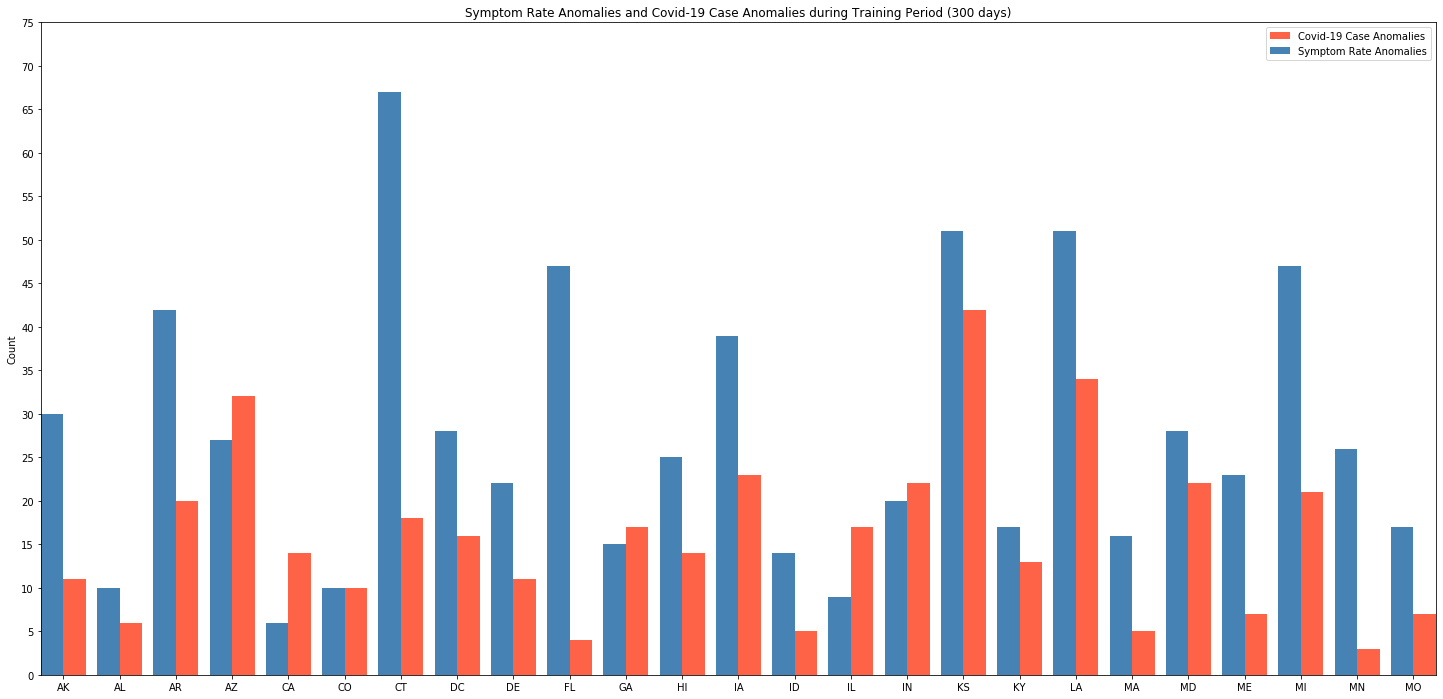

In [53]:
fig = plt.figure(figsize=(25, 12))
ax = fig.add_subplot(111)
_X = np.arange(25)
X = [state[3:] for state in STATES[:25]]
ax.bar(_X + 0.2, [int(L_window) for L_window in total_real_anomalies[:25]], width=0.4, color='tomato', align='center', label="Covid-19 Case Anomalies")
ax.bar(_X - 0.2, [int(TP_FP[0]+TP_FP[1]) for TP_FP in state_TP_FP[:25]], width=0.4, color='steelblue', align='center', label="Symptom Rate Anomalies")
ax.autoscale(tight=True)
plt.xticks(_X, X)
plt.yticks(range(0, 80, 5))
plt.title("Symptom Rate Anomalies and Covid-19 Case Anomalies during Training Period (300 days)")
plt.ylabel("Count")
plt.legend()
plt.show()

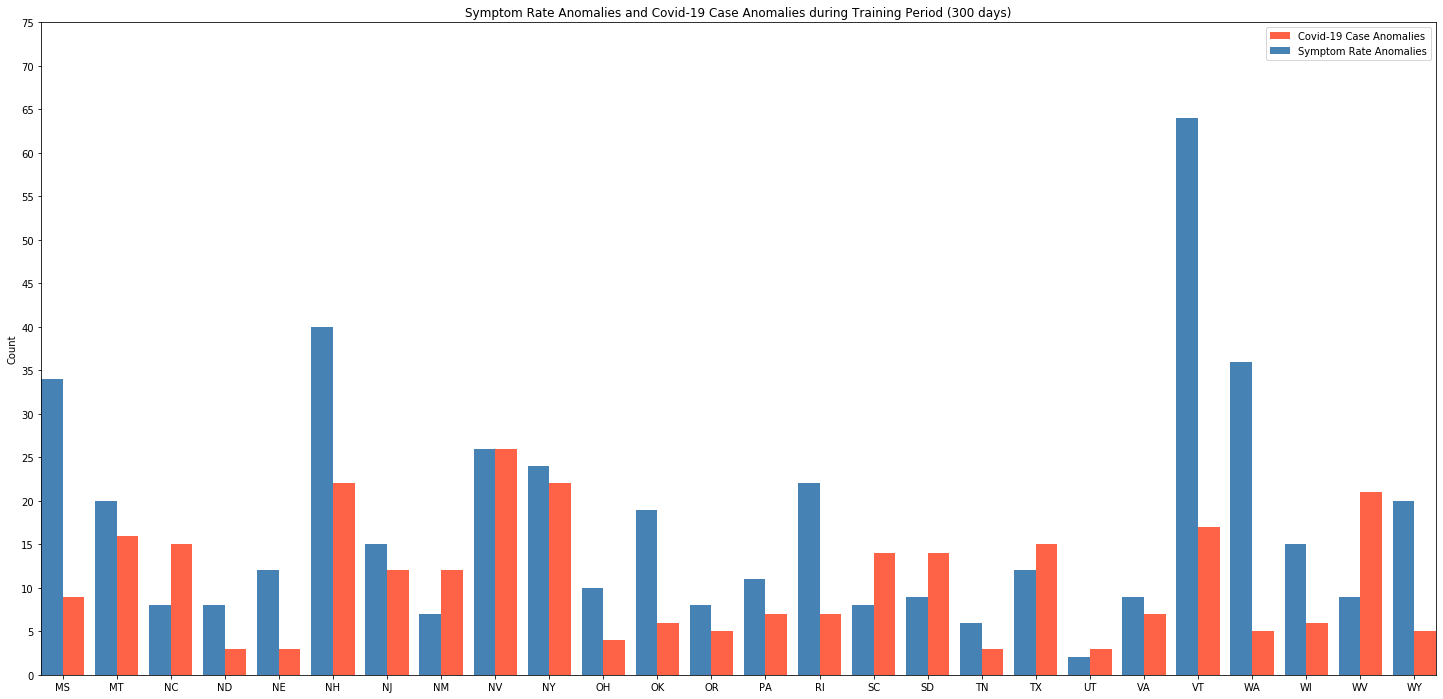

In [54]:
fig = plt.figure(figsize=(25, 12))
ax = fig.add_subplot(111)
_X = np.arange(26)
X = [state[3:] for state in STATES[25:]]
ax.bar(_X + 0.2, [int(L_window) for L_window in total_real_anomalies[25:]], width=0.4, color='tomato', align='center', label="Covid-19 Case Anomalies")
ax.bar(_X - 0.2, [int(TP_FP[0]+TP_FP[1]) for TP_FP in state_TP_FP[25:]], width=0.4, color='steelblue', align='center', label="Symptom Rate Anomalies")
ax.autoscale(tight=True)
plt.xticks(_X, X)
plt.yticks(range(0, 80, 5))
plt.title("Symptom Rate Anomalies and Covid-19 Case Anomalies during Training Period (300 days)")
plt.ylabel("Count")
plt.legend()
plt.show()

# EXPERIMENT 4: 2dp TH

In [55]:
# # return TP_FP, FN, precision, recall, Fscore
# TH_EXP4 = np.arange(0,2,0.01)
# lag_EXP4 = np.arange(0,31)
# final_best_th_lag_EXP4 = np.zeros((NUM_STATES,2))

# for idx_s, state in enumerate(STATES):
#     best_th_lag_EXP4 = np.zeros(2)
#     best_lag_EXP4 = 0
#     best_f_score_EXP4 = 0
#     target = state[3:]
#     L = covid_case_outbreak_detection_all(actual_all, target)
#     for idx_th, th in enumerate(TH_EXP4):
#         for idx_l, l in enumerate(lag_EXP4):   
            
#             L_hat = pred_outbreak_detection(new_delta, L_hat_period_all, th)
#             all_S, L_window = comparison_all(state, L, L_hat, l)
#             metr = metrics(all_S, L_window)
            
#             if metr[4] > best_f_score_EXP4:
#                 best_th_lag_EXP4[0] = th
#                 best_th_lag_EXP4[1] = l
#                 best_f_score_EXP4 = metr[4]
                
#     final_best_th_lag_EXP4[idx_s] = best_th_lag_EXP4

In [56]:
# state_TP_FP_EXP4 = np.zeros((NUM_STATES,2))
# state_FN_EXP4 = np.zeros(NUM_STATES)
# state_fscore_EXP4 = np.zeros(NUM_STATES)
# state_precision_EXP4 = np.zeros(NUM_STATES)
# state_recall_EXP4 = np.zeros(NUM_STATES)

# total_real_anomalies_EXP4 = np.zeros(NUM_STATES)

# for idx_s, state in enumerate(STATES):
#     target = state[3:]    
#     L = covid_case_outbreak_detection_all(actual_all, target)
            
#     L_hat = pred_outbreak_detection(new_delta, L_hat_period_all, final_best_th_lag_EXP4[idx_s][0])
    
#     all_S, L_window = comparison_all(state, L, L_hat, int(final_best_th_lag_EXP4[idx_s][1]))
#     total_real_anomalies_EXP4[idx_s] = np.sum(L_window)
#     metr = metrics(all_S, L_window)
    
#     state_TP_FP_EXP4[idx_s] = metr[0]
#     state_FN_EXP4[idx_s] = metr[1]
#     state_precision_EXP4[idx_s] = metr[2]
#     state_recall_EXP4[idx_s] = metr[3]
#     state_fscore_EXP4[idx_s] = metr[4]

In [57]:
# np.savetxt("state_TP_FP_EXP4.csv", state_TP_FP_EXP4, delimiter=",")
# np.savetxt("state_FN_EXP4.csv", state_FN_EXP4, delimiter=",")
# np.savetxt("state_precision_EXP4.csv", state_precision_EXP4, delimiter=",")
# np.savetxt("state_recall_EXP4.csv", state_recall_EXP4, delimiter=",")
# np.savetxt("state_fscore_EXP4.csv", state_fscore_EXP4, delimiter=",")
# np.savetxt("total_real_anomalies_EXP4.csv", total_real_anomalies_EXP4, delimiter=",")
# np.savetxt("state_best_th_lag_EXP4.csv", final_best_th_lag_EXP4, delimiter=",")

In [58]:
# fig = plt.figure(figsize=(25, 12))
# ax = fig.add_subplot(111)
# _X = np.arange(NUM_STATES)
# X = [state[3:] for state in STATES]
# ax.bar(_X + 0.2, [int(TP_FP[0]+TP_FP[1]) for TP_FP in state_TP_FP], width=0.4, color='tomato', align='center', label="Orginal")
# ax.bar(_X - 0.2, [int(TP_FP[0]+TP_FP[1]) for TP_FP in state_TP_FP_EXP4], width=0.4, color='steelblue', align='center', label="New")
# ax.autoscale(tight=True)
# plt.xticks(_X, X)
# plt.yticks(range(0, 80, 5))
# plt.title("Symptom Rate Anomalies (Original) and Symptom Rate Anomalies (Smaller TH)")
# plt.ylabel("Count")
# plt.legend()
# plt.show()

## Experiment 5 for DEBUGGING

In [59]:
# new_delta_debug = np.concatenate((new_delta, new_delta_Jan21), axis=0)
# L_hat_debug_period = new_delta_debug.shape[0]
# print(L_hat_debug_period)
# print(new_delta.shape)

In [60]:
# for state in STATES: 
#     best_th_lag = np.zeros(2)
#     best_lag = 0
#     best_f_score = 0
    
#     target = get_target_region_idx(state) 
#     L_debug = pred_outbreak_detection(new_delta, L_hat_period_all, 1).transpose()[target]
    
#     L_hat = pred_outbreak_detection(new_delta, L_hat_period_all, 1)
#     all_S, L_window = comparison_all(state, L_debug, L_hat, 0)

#     metr = metrics(all_S, L_window)
#     if metr[4] > best_f_score:
#         best_th_lag[0] = th
#         best_th_lag[1] = l
#         best_f_score = metr[4]
#     print(state + " " + str(best_f_score))

In [61]:
# for state in STATES: 
#     best_th_lag = np.zeros(2)
#     best_lag = 0
#     best_f_score = 0
    
#     target = get_target_region_idx(state)
#     L_debug = pred_outbreak_detection(new_delta_debug, L_hat_debug_period, 1).transpose()[target]
    
#     for idx_th, th in enumerate(TH):
#         for idx_l, l in enumerate(lag):   

#             L_hat = pred_outbreak_detection(new_delta, L_hat_period_all, th)
#             all_S, L_window = comparison_all(state, L_debug, L_hat, l)

#             metr = metrics(all_S, L_window)
#             if metr[4] > best_f_score:
#                 best_th_lag[0] = th
#                 best_th_lag[1] = l
#                 best_f_score = metr[4]
    
#     print(state + " " + str(best_f_score) + " lag " + str(best_th_lag[1]) + " th " + str(best_th_lag[0]))

In [62]:
# for state in ["US-IL"]: 
#     best_th_lag = np.zeros(2)
#     best_lag = 0
#     best_f_score = 0
    
#     target = get_target_region_idx(state)
#     L_debug = pred_outbreak_detection(new_delta_debug, L_hat_debug_period, 1).transpose()[target]
    
#     for idx_th, th in enumerate([1.0]):
#         for idx_l, l in enumerate([0]):   
#             print("TH lag " + str(th) + " , " + str(l))
            
#             L_hat = pred_outbreak_detection(new_delta, L_hat_period_all, 1.0)
#             all_S, L_window = comparison_all(state, L_debug, L_hat, 0)

#             metr = metrics(all_S, L_window)
#             print("best", best_f_score)
#             print("curr", metr[4])
#             if metr[4] > best_f_score:
#                 best_th_lag[0] = th
#                 best_th_lag[1] = l
#                 best_f_score = metr[4]
#     print(state + " " + str(best_f_score) + " lag " + str(best_th_lag[1]) + " th " + str(best_th_lag[0]))

# Analysis: Threshold Analysis

## CT

(array([15., 52.]), 3.0, 0.22388059701492538, 0.8333333333333334, 0.3529411764705882)


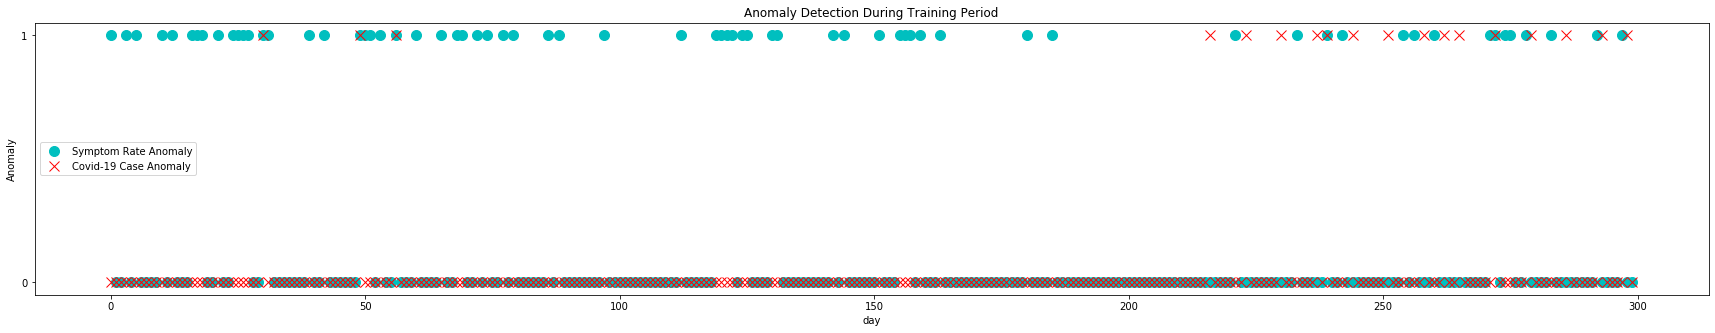

In [75]:
# precision, recall, Fscore
state_lag = 3
state_th = 0.1
CT = get_target_region_idx("US-CT")

L_CT = covid_case_outbreak_detection_all(actual_all, "CT")

L_hat_CT = pred_outbreak_detection(new_delta, L_hat_period_all, state_th)
CT_S, L_window_CT = comparison_all("US-CT", L_CT, L_hat_CT, state_lag)

print(metrics(CT_S, L_window_CT))

fig, ax = plt.subplots(1, 1)
fig.set_figheight(5)
fig.set_figwidth(30)

ax.set_ylabel("Anomaly")
ax.set_xlabel("day")
ax.set_title("Anomaly Detection During Training Period")
ax.set_yticks(np.array([0,1]))
ax.plot(np.array(range(300)),L_hat_CT.transpose()[CT], marker='o',  markersize=10, color='c', linewidth=0, label="Symptom Rate Anomaly")
ax.plot(np.array(range(300)),L_window_CT, marker='x',  markersize=10, color='r', linewidth=0, label="Covid-19 Case Anomaly")
ax.legend(loc="center left")

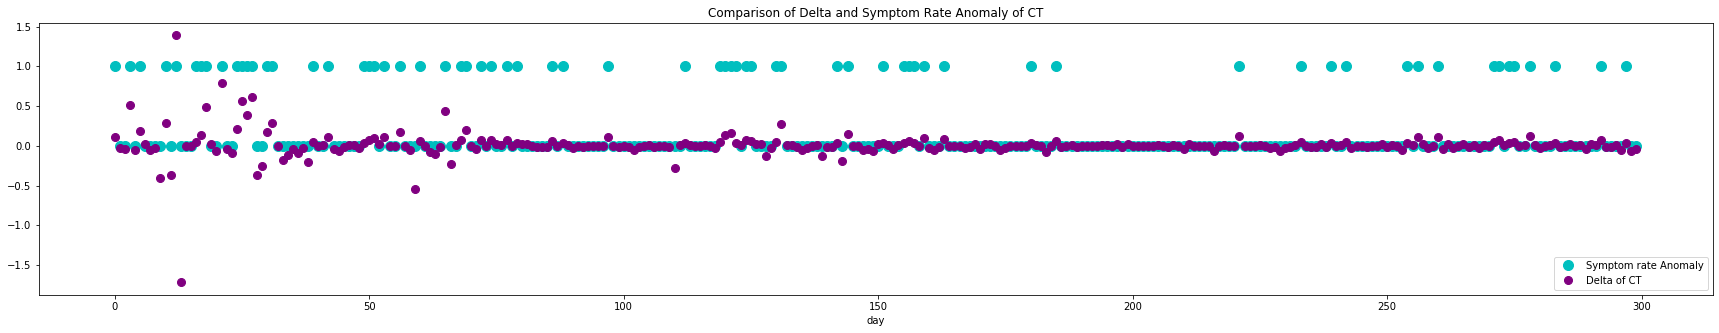

In [76]:
fig, ax = plt.subplots(1, 1)
fig.set_figheight(5)
fig.set_figwidth(30)
ax.set_xlabel("day")
ax.set_title("Comparison of Delta and Symptom Rate Anomaly of CT")
ax.plot(np.array(range(300)),L_hat_CT.transpose()[CT], marker='o',  markersize=10, color='c', linewidth=0, label="Symptom rate Anomaly")
ax.plot(np.array(range(300)),new_delta.transpose()[CT], marker='o',  markersize=8, color='purple', linewidth=0, label="Delta of CT")
ax.legend(loc="lower right")

Text(0, 0.5, 'F score')

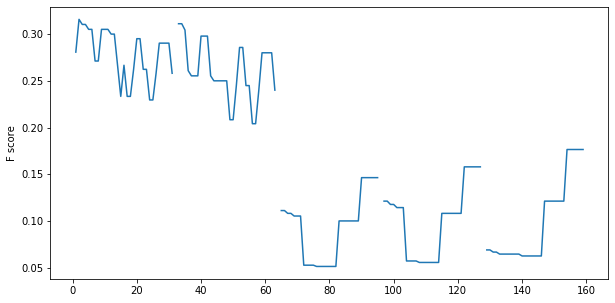

In [77]:
f_score = []
for th in np.arange(0.3, 1.3, 0.2):
    f_score.append(np.nan)
    for l in range(31):
        L_hat_CT = pred_outbreak_detection(new_delta, L_hat_period_all, th)
        CT_S, L_window_CT = comparison_all("US-CT", L_CT, L_hat_CT, l)
        metr_CT = metrics(CT_S, L_window_CT)
        f_score.append(metr_CT[4])
plt.figure(figsize=(10,5))
plt.plot(f_score)
plt.ylabel("F score")

## VT

(array([1., 7.]), 17.0, 0.125, 0.05555555555555555, 0.07692307692307691)


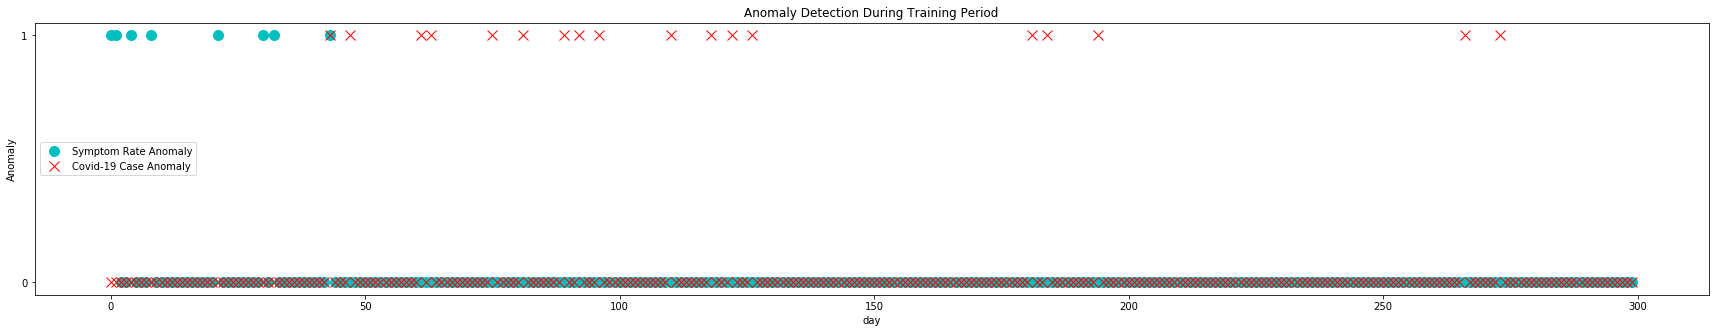

In [78]:
# precision, recall, Fscore
state_lag = 28
state_th = 1.1
VT = get_target_region_idx("US-VT")

L_VT = covid_case_outbreak_detection_all(actual_all, "VT")

L_hat_VT = pred_outbreak_detection(new_delta, L_hat_period_all, state_th)
VT_S, L_window_VT = comparison_all("US-VT", L_VT, L_hat_VT, state_lag)

print(metrics(VT_S, L_window_VT))

fig, ax = plt.subplots(1, 1)
fig.set_figheight(5)
fig.set_figwidth(30)

ax.set_ylabel("Anomaly")
ax.set_xlabel("day")
ax.set_title("Anomaly Detection During Training Period")
ax.set_yticks(np.array([0,1]))
ax.plot(np.array(range(300)),L_hat_VT.transpose()[VT], marker='o',  markersize=10, color='c', linewidth=0, label="Symptom Rate Anomaly")
ax.plot(np.array(range(300)),L_window_VT, marker='x',  markersize=10, color='r', linewidth=0, label="Covid-19 Case Anomaly")
ax.legend(loc="center left")

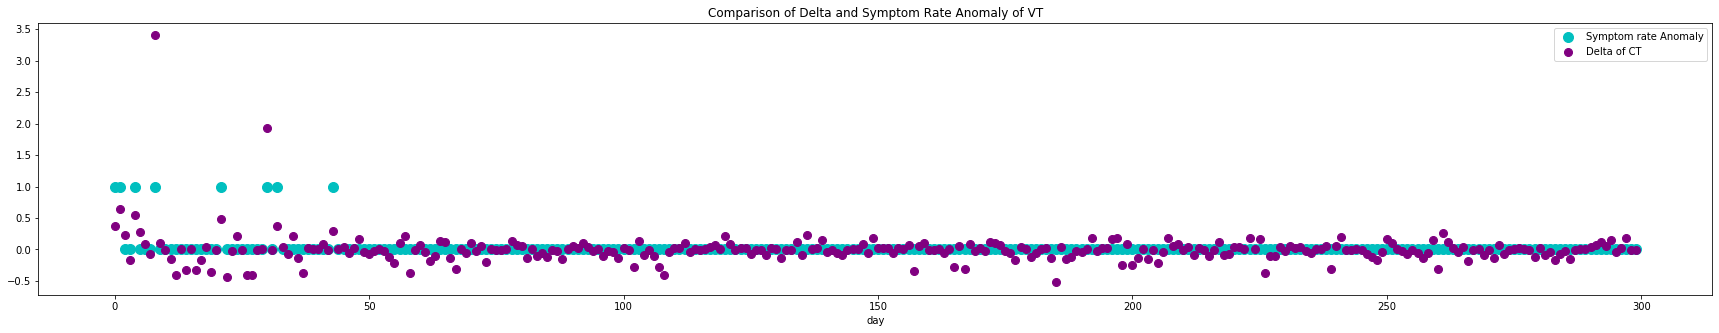

In [79]:
fig, ax = plt.subplots(1, 1)
fig.set_figheight(5)
fig.set_figwidth(30)
ax.set_xlabel("day")
ax.set_title("Comparison of Delta and Symptom Rate Anomaly of VT")
ax.plot(np.array(range(300)),L_hat_VT.transpose()[VT], marker='o',  markersize=10, color='c', linewidth=0, label="Symptom rate Anomaly")
ax.plot(np.array(range(300)),new_delta.transpose()[VT], marker='o',  markersize=8, color='purple', linewidth=0, label="Delta of CT")
ax.legend(loc="upper right")

Text(0, 0.5, 'F score')

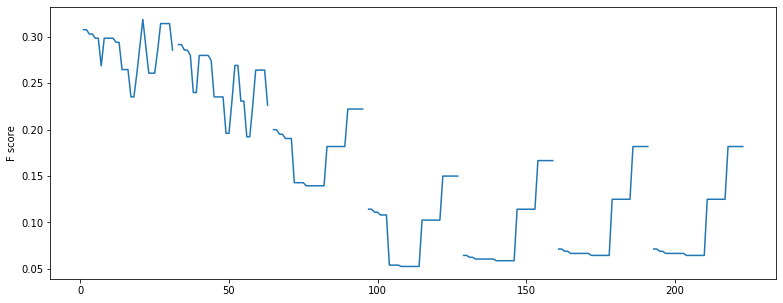

In [80]:
f_score = []
for th in np.arange(0.2, 1.6, 0.2):
    f_score.append(np.nan)
    for l in range(31):
        L_hat_CT = pred_outbreak_detection(new_delta, L_hat_period_all, th)
        CT_S, L_window_CT = comparison_all("US-CT", L_CT, L_hat_CT, l)
        metr_CT = metrics(CT_S, L_window_CT)
        f_score.append(metr_CT[4])
plt.figure(figsize=(13,5))
plt.plot(f_score)
plt.ylabel("F score")

# EXPERIMENTATION 2: FALSE Anomalies

In [64]:
# # Histogram purposes
# def covid_case_outbreak_detection_hist(X, target_region, minimum):
#     X_target = X[X.state == target_region].drop(['date', 'state'], axis=1).to_numpy().flatten()
#     X_target[X_target < 1] = 1
#     assert np.any(X_target < 1) == False, "Actual Cases < 1"
#     period = len(X_target) 
#     C = np.zeros(period)
#     for idx, X_day in enumerate(X_target):
#         if idx == 0:
#             continue  
#         Cd = np.divide(np.subtract(X_day, X_target[idx-1]), X_target[idx-1])
#         C[idx] = Cd   
#     temp = np.copy(C)
#     std_C = np.std(C)
#     temp[temp > (3 * std_C)] = 0
#     std_C = np.std(temp)
#     assert std_C != 0, "Std C is 0"
#     L_score = C > (2 * std_C)
#     L_score = L_score.astype(int)
#     anomaly_cases = np.array([X_target[idx] for idx, l in enumerate(L_score) if l == 1 and X_target[idx] < minimum])
#     return anomaly_cases

# # FOR ALL STATES
# small_anoms = np.zeros(NUM_STATES)
# actual_case_count_training = np.zeros(NUM_STATES)
# for idx_s, state in enumerate(STATES):
#     actual_case_count_training[idx_s] = np.sum(covid_case_outbreak_detection_all(actual_all, state[3:]))
#     small_anoms[idx_s] = len(covid_case_outbreak_detection_hist(actual_all, state[3:], 50))

# fig = plt.figure(figsize=(25, 12))
# ax = fig.add_subplot(111)
# _X = np.arange(NUM_STATES)
# X = [state[3:] for state in STATES]
# ax.bar(_X + 0.2, small_anoms, width=0.4, color='tomato', align='center', label="False Anomalies")
# ax.bar(_X - 0.2, actual_case_count_training, width=0.4, color='steelblue', align='center', label="Anomalies")
# ax.autoscale(tight=True)
# plt.xticks(_X, X)
# plt.title("False Anomalies and Covid-19 Case Anomalies during Training Period")
# plt.ylabel("Count")
# plt.legend()
# plt.show()

## Experiment 3: Linear Correlation

From 7 March 2020 - 31 Dec 2020

Aggregated

In [81]:
# symptoms = F[(F.date >= '2020-03-07') & (F.date <= '2020-12-31')]
# # (Symptom, Period)
# symptoms_aggregated = symptoms.groupby('date').sum().to_numpy().transpose()

# cases_for_corr_agg = actual_cases[(actual_cases.date >= '2020-03-07') & (actual_cases.date <= '2020-12-31')]
# cases_for_corr_agg = cases_for_corr_agg.groupby('date').sum().to_numpy()
# scaler = MinMaxScaler(feature_range=(0, 1))
# normalised_cases = scaler.fit_transform(cases_for_corr_agg).flatten()

# corr_agg = []
# for idx_s, symp in enumerate(SYMP_LIST):
#     corr_agg.append(np.array(stats.pearsonr(symptoms_aggregated[idx_s], normalised_cases)))

In [66]:
# fig, ax = plt.subplots(figsize=(10,7))

# # Example data
# y_pos = np.arange(NUM_SYMP)
# ax.barh(y_pos, [c[0] for c in corr_agg], align='center')
# ax.set_yticks(y_pos)
# ax.set_yticklabels([s[8:] for s in SYMP_LIST])
# ax.invert_yaxis()  # labels read top-to-bottom
# ax.set_xlabel('Pearson Correlation, r')
# ax.set_title('Pearson Correlation of Aggregated Symptom Rates and Aggregated New Covid-19 Cases')

In [67]:
# fig, ax = plt.subplots(figsize=(10,7))
# x = symptoms_aggregated[-6]
# ax.scatter(x, normalised_cases)
# ax.set_xlabel('Aggregated Symptom Rate: Clouding of Consciousness')
# ax.set_ylabel('Normalized Daily Covid-19 Cases')
# ax.set_title('Symptom Rate: Clouding of Consciousness')
# z = np.polyfit(x, normalised_cases, 1)
# p = np.poly1d(z)
# plt.plot(x,p(x),"r--")
# plt.show()

# EXPERIMENTATION 6: SMOOTHING (Moving Average to Prepare Dataset)

Checking if the data is stationary: 1st Jan - 31 Dec (366 datapoints)

In [39]:
from statsmodels.tsa.stattools import adfuller
print(" > Is the data stationary ?")
dftest = adfuller(new_delta.transpose()[0], autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value =  {:.8f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

 > Is the data stationary ?
Test statistic = -5.628
P-value =  0.00000110
Critical values :
	1%: -3.4531816058796143 - The data is  stationary with 99% confidence
	5%: -2.871593390724642 - The data is  stationary with 95% confidence
	10%: -2.5721268156511536 - The data is  stationary with 90% confidence


### w = 3 Visualisations

Loading Data

In [42]:
Mar_smooth = load('results/smoothing_delta/sMar20_01_31.npy')
Apr_smooth = load('results/smoothing_delta/sApr20_01_30.npy')
May_smooth = load('results/smoothing_delta/sMay20_01_31.npy')
Jun_smooth = load('results/smoothing_delta/sJun20_01_30.npy')
Jul_smooth = load('results/smoothing_delta/sJul20_01_31.npy')
Aug_smooth = load('results/smoothing_delta/sAug20_01_31.npy')
Sept_smooth = load('results/smoothing_delta/sSept20_01_30.npy')
Oct_smooth = load('results/smoothing_delta/sOct20_01_31.npy')
Nov_smooth = load('results/smoothing_delta/sNov20_01_30.npy')
Dec_smooth = load('results/smoothing_delta/sDec20_01_31.npy')

In [43]:
new_delta_sMar = new_delta_mat(Mar_smooth, period_31, 4, 7)[6:]
new_delta_sApr = new_delta_mat(Apr_smooth, period_30, 4, 7)
new_delta_sMay = new_delta_mat(May_smooth, period_31, 4, 7)
new_delta_sJun = new_delta_mat(Jun_smooth, period_30, 4, 7)
new_delta_sJul = new_delta_mat(Jul_smooth, period_31, 4, 7)
new_delta_sAug = new_delta_mat(Aug_smooth, period_31, 4, 7)
new_delta_sSept = new_delta_mat(Sept_smooth, period_30, 4, 7)
new_delta_sOct = new_delta_mat(Oct_smooth, period_31, 4, 7)
new_delta_sNov = new_delta_mat(Nov_smooth, period_30, 4, 7)
new_delta_sDec = new_delta_mat(Dec_smooth, period_31, 4, 7)
# new_delta_Jan21 = new_delta_mat(data_Jan21, period_31, 4, 7)
# new_delta_Feb21 = new_delta_mat(data_Feb21, period_feb, 4, 7)

# Joining of new delta: 7th Mar - Jan 2021
new_Sdelta = np.concatenate((new_delta_sMar, new_delta_sApr), axis=0)
new_Sdelta = np.concatenate((new_Sdelta, new_delta_sMay), axis=0)
new_Sdelta = np.concatenate((new_Sdelta, new_delta_sJun), axis=0)
new_Sdelta = np.concatenate((new_Sdelta, new_delta_sJul), axis=0)
new_Sdelta = np.concatenate((new_Sdelta, new_delta_sAug), axis=0)
new_Sdelta = np.concatenate((new_Sdelta, new_delta_sSept), axis=0)
new_Sdelta = np.concatenate((new_Sdelta, new_delta_sOct), axis=0)
new_Sdelta = np.concatenate((new_Sdelta, new_delta_sNov), axis=0)
new_Sdelta = np.concatenate((new_Sdelta, new_delta_sDec), axis=0)

Comparison of delta original and delta smooth (US-CA, w=3)

Text(0.5, 1.0, 'Comparison of delta of original Symptom Rates and smoothed Symptom Rates (US-CA, w=3)')

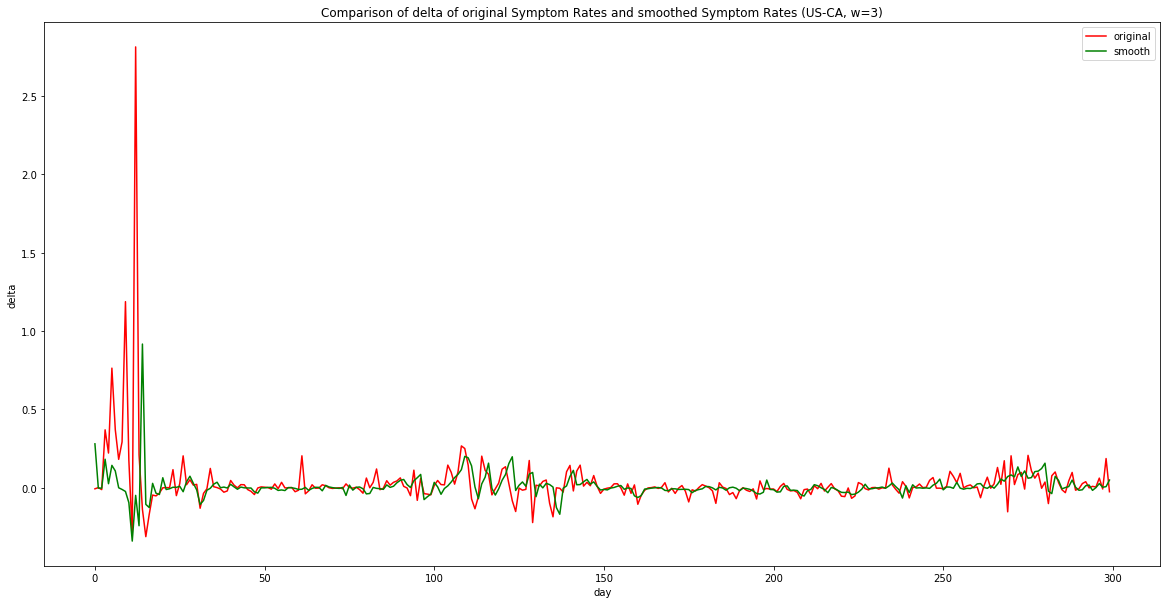

In [44]:
fig = plt.figure(figsize=(20, 10))
plt.plot(new_delta.transpose()[4], color='r', label="original")
plt.plot(new_Sdelta.transpose()[4], color='g',label="smooth")
plt.legend()
plt.xlabel("day")
plt.ylabel("delta")
plt.title("Comparison of delta of original Symptom Rates and smoothed Symptom Rates (US-CA, w=3)")

Getting F-scores and Metrics

In [ ]:
# return TP_FP, FN, precision, recall, Fscore
TH = np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0])
# TH = 0
lag = np.arange(0,31)
state_best_th_lag = np.zeros((NUM_STATES,2))

for idx_s, state in enumerate(STATES):
    best_th_lag = np.zeros(2)
    best_lag = 0
    best_f_score = 0
    target = state[3:]
    L = covid_case_outbreak_detection_all(actual_all, target)
    for idx_th, th in enumerate(TH):
        for idx_l, l in enumerate(lag):   
            
            L_hat = pred_outbreak_detection(new_Sdelta, L_hat_period_all, th)
            all_S, L_window = comparison_all(state, L, L_hat, l)
            metr = metrics(all_S, L_window)
            
            if metr[4] > best_f_score:
                best_th_lag[0] = th
                best_th_lag[1] = l
                best_f_score = metr[4]
                
    state_best_th_lag[idx_s] = best_th_lag
np.save("best_th_lag_smooth.npy", state_best_th_lag)

In [94]:
state_best_th_lag_S = load('best_th_lag_smooth.npy')
state_TP_FP_S = np.zeros((NUM_STATES,2))
state_FN_S = np.zeros(NUM_STATES)
state_fscore_S = np.zeros(NUM_STATES)
state_precision_S = np.zeros(NUM_STATES)
state_recall_S = np.zeros(NUM_STATES)

total_real_anomalies_S = np.zeros(NUM_STATES)

for idx_s, state in enumerate(STATES):
    target = state[3:]    
    L_S = covid_case_outbreak_detection_all(actual_all, target)
            
    L_hat_S = pred_outbreak_detection(new_Sdelta, L_hat_period_all, state_best_th_lag_S[idx_s][0])
    
    all_S_smooth, L_window_S = comparison_all(state, L_S, L_hat_S, int(state_best_th_lag_S[idx_s][1]))
    
    total_real_anomalies_S[idx_s] = np.sum(L_window_S)
    metr = metrics(all_S_smooth, L_window_S)
    state_TP_FP_S[idx_s] = metr[0]
    state_FN_S[idx_s] = metr[1]
    state_precision_S[idx_s] = metr[2]
    state_recall_S[idx_s] = metr[3]
    state_fscore_S[idx_s] = metr[4]

saving

In [95]:
# np.savetxt("state_TP_FP_S.csv", state_TP_FP_S, delimiter=",")
# np.savetxt("state_FN_S.csv", state_FN_S, delimiter=",")
# np.savetxt("state_precision_S.csv", state_precision_S, delimiter=",")
# np.savetxt("state_recall_S.csv", state_recall_S, delimiter=",")
# np.savetxt("state_fscore_S.csv", state_fscore_S, delimiter=",")
# np.savetxt("total_real_anomalies_S.csv", total_real_anomalies_S, delimiter=",")
# np.savetxt("state_best_th_lag_S.csv", state_best_th_lag_S, delimiter=",")

Getting __Non-Smoothed__ Metrics

In [185]:
##NON SMOOTHING
state_best_th_lag_ori = load('best_th_lag_V3.npy')

state_TP_FP_ori = np.zeros((NUM_STATES,2))
state_FN_ori = np.zeros(NUM_STATES)
state_fscore_ori = np.zeros(NUM_STATES)
state_precision_ori = np.zeros(NUM_STATES)
state_recall_ori = np.zeros(NUM_STATES)
total_real_anomalies_ori = np.zeros(NUM_STATES)

for idx_s, state in enumerate(STATES):
    target = state[3:]    
    L_ori = covid_case_outbreak_detection_all(actual_all, target)
            
    L_hat_ori = pred_outbreak_detection(new_delta, L_hat_period_all, state_best_th_lag_ori[idx_s][0])
    
    all_S_ori, L_window_ori = comparison_all(state, L_ori, L_hat_ori, int(state_best_th_lag_ori[idx_s][1]))
    
    total_real_anomalies_ori[idx_s] = np.sum(L_window_ori)
    metr_ori = metrics(all_S_ori, L_window_ori)
    
    state_TP_FP_ori[idx_s] = metr_ori[0]
    state_FN_ori[idx_s] = metr_ori[1]
    state_precision_ori[idx_s] = metr_ori[2]
    state_recall_ori[idx_s] = metr_ori[3]
    state_fscore_ori[idx_s] = metr_ori[4]

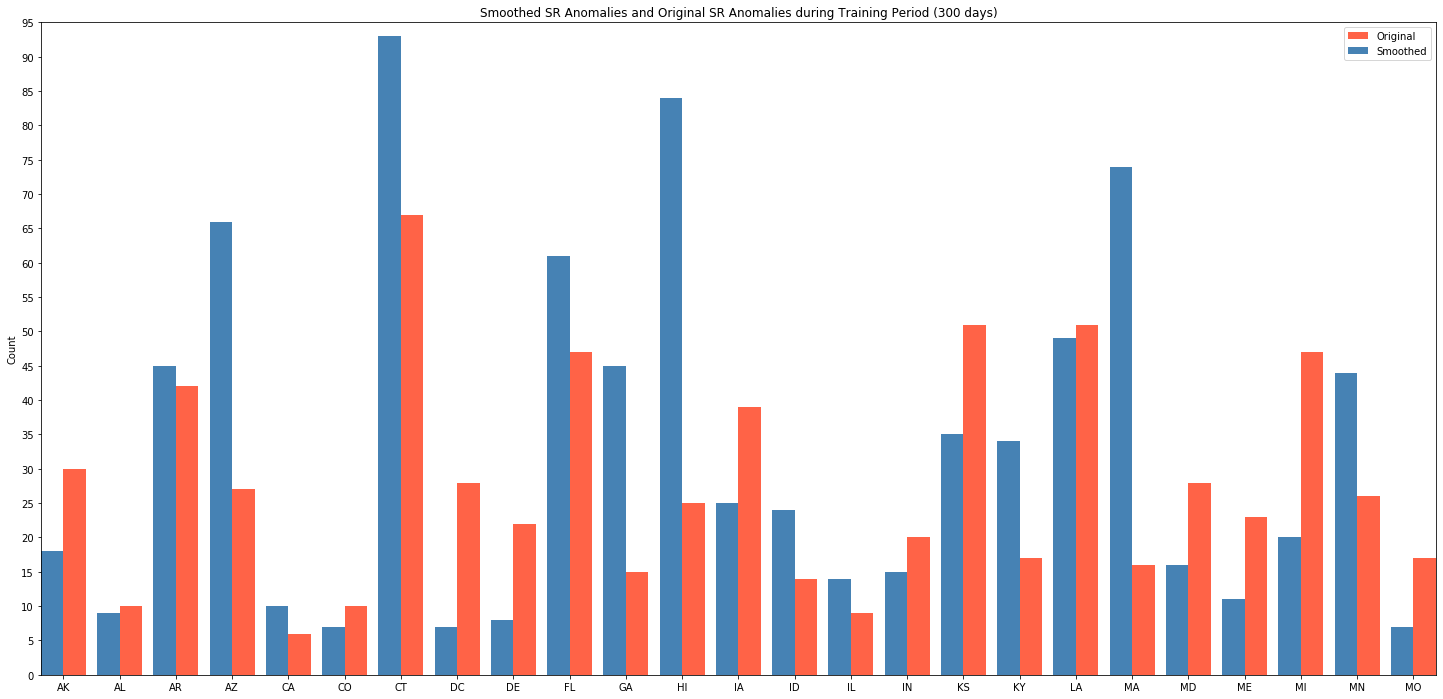

In [97]:
fig = plt.figure(figsize=(25, 12))
ax = fig.add_subplot(111)
_X = np.arange(25)
X = [state[3:] for state in STATES[:25]]
ax.bar(_X + 0.2, [int(TP_FP[0]+TP_FP[1]) for TP_FP in state_TP_FP_ori[:25]], width=0.4, color='tomato', align='center', label="Original")
ax.bar(_X - 0.2, [int(TP_FP[0]+TP_FP[1]) for TP_FP in state_TP_FP_S[:25]], width=0.4, color='steelblue', align='center', label="Smoothed")
ax.autoscale(tight=True)
plt.xticks(_X, X)
plt.yticks(range(0, 100, 5))
plt.title("Smoothed SR Anomalies and Original SR Anomalies during Training Period (300 days)")
plt.ylabel("Count")
plt.legend()
plt.show()

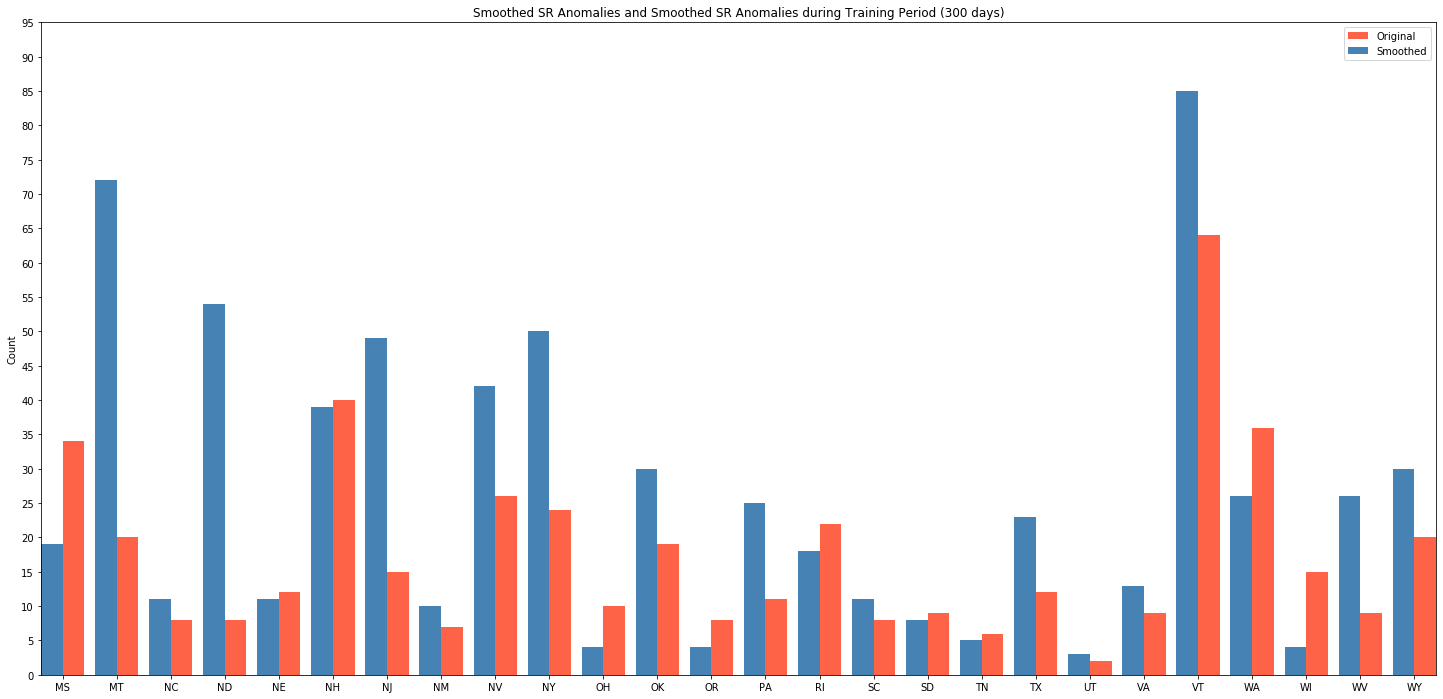

In [100]:
fig = plt.figure(figsize=(25, 12))
ax = fig.add_subplot(111)
_X = np.arange(26)
X = [state[3:] for state in STATES[25:]]
ax.bar(_X + 0.2, [int(TP_FP[0]+TP_FP[1]) for TP_FP in state_TP_FP_ori[25:]], width=0.4, color='tomato', align='center', label="Original")
ax.bar(_X - 0.2, [int(TP_FP[0]+TP_FP[1]) for TP_FP in state_TP_FP_S[25:]], width=0.4, color='steelblue', align='center', label="Smoothed")
ax.autoscale(tight=True)
plt.xticks(_X, X)
plt.yticks(range(0, 100, 5))
plt.title("Smoothed SR Anomalies and Smoothed SR Anomalies during Training Period (300 days)")
plt.ylabel("Count")
plt.legend()
plt.show()

### Smoothing CT

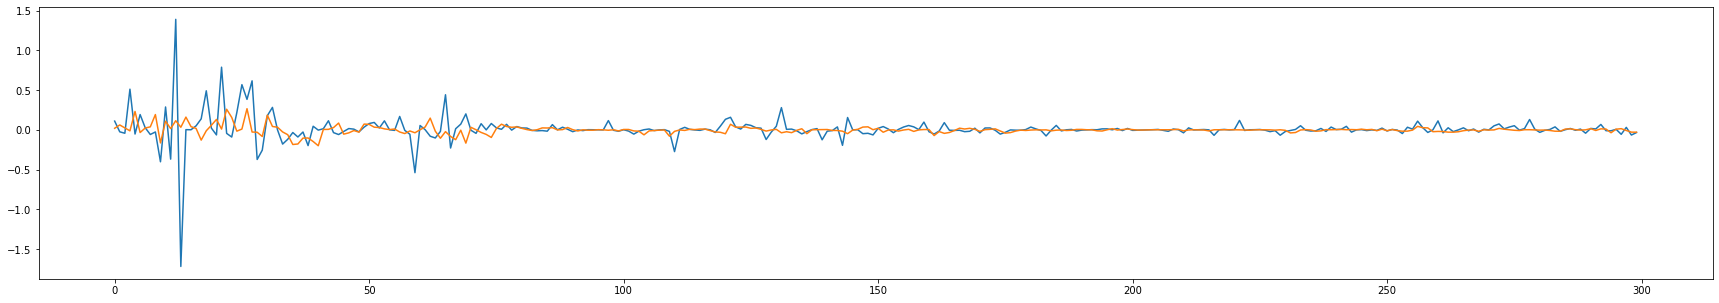

In [104]:
fig, ax = plt.subplots(1, 1)
fig.set_figheight(5)
fig.set_figwidth(30)
plt.plot(new_delta.transpose()[CT])
plt.plot(new_Sdelta.transpose()[CT])

(array([15., 78.]), 7.0, 0.16129032258064516, 0.6818181818181818, 0.2608695652173913)


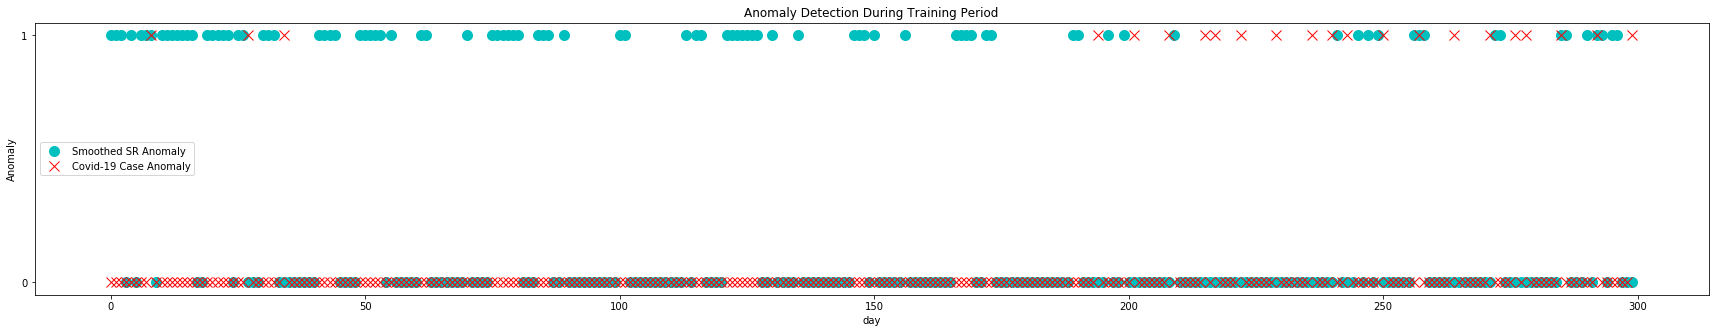

In [107]:
# precision, recall, Fscore

CT = get_target_region_idx("US-CT")
# Smoothing best TH LAG
state_lag = 25
state_th = 0.1

L_CT = covid_case_outbreak_detection_all(actual_all, "CT")
L_hat_CT = pred_outbreak_detection(new_Sdelta, L_hat_period_all, state_th)
CT_S, L_window_CT = comparison_all("US-CT", L_CT, L_hat_CT, state_lag)

print(metrics(CT_S, L_window_CT))

fig, ax = plt.subplots(1, 1)
fig.set_figheight(5)
fig.set_figwidth(30)
ax.set_ylabel("Anomaly")
ax.set_xlabel("day")
ax.set_title("Anomaly Detection During Training Period")
ax.set_yticks(np.array([0,1]))
ax.plot(np.array(range(300)), L_hat_CT.transpose()[CT], marker='o',  markersize=10, color='c', linewidth=0, label="Smoothed SR Anomaly")
ax.plot(np.array(range(300)), L_window_CT, marker='x',  markersize=10, color='r', linewidth=0, label="Covid-19 Case Anomaly")
ax.legend(loc="center left")

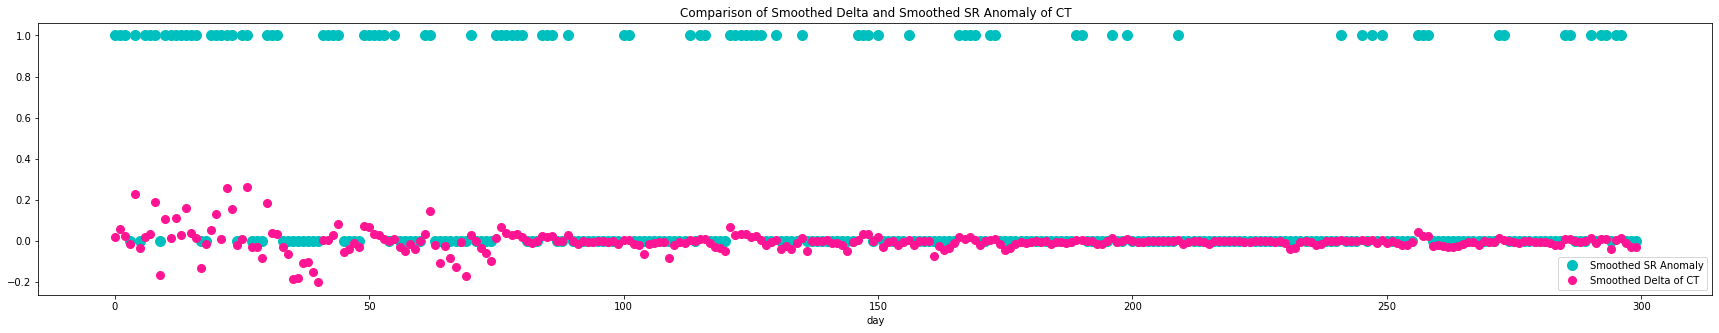

In [85]:
fig, ax = plt.subplots(1, 1)
fig.set_figheight(5)
fig.set_figwidth(30)
ax.set_xlabel("day")
ax.set_title("Comparison of Smoothed Delta and Smoothed SR Anomaly of CT")
ax.plot(np.array(range(300)),L_hat_CT.transpose()[CT], marker='o',  markersize=10, color='c', linewidth=0, label="Smoothed SR Anomaly")
ax.plot(np.array(range(300)),new_Sdelta.transpose()[CT], marker='o',  markersize=8, color='deeppink', linewidth=0, label="Smoothed Delta of CT")
ax.legend(loc="lower right")

Delta comparisons

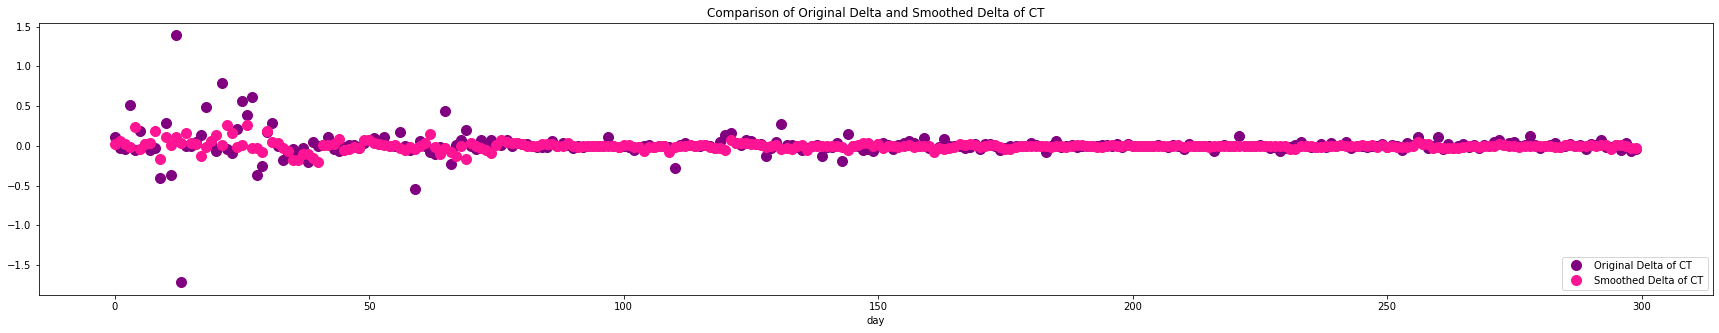

In [101]:
fig, ax = plt.subplots(1, 1)
fig.set_figheight(5)
fig.set_figwidth(30)
ax.set_xlabel("day")
ax.set_title("Comparison of Original Delta and Smoothed Delta of CT")
ax.plot(np.array(range(300)),new_delta.transpose()[CT], marker='o',  markersize=10, color='purple', linewidth=0, label="Original Delta of CT")
ax.plot(np.array(range(300)),new_Sdelta.transpose()[CT], marker='o',  markersize=10, color='deeppink', linewidth=0, label="Smoothed Delta of CT")
ax.legend(loc="lower right")

mean 0.010588360669699063
0.17291634879574147
mean -0.0016879916567051404
0.05136749187248113


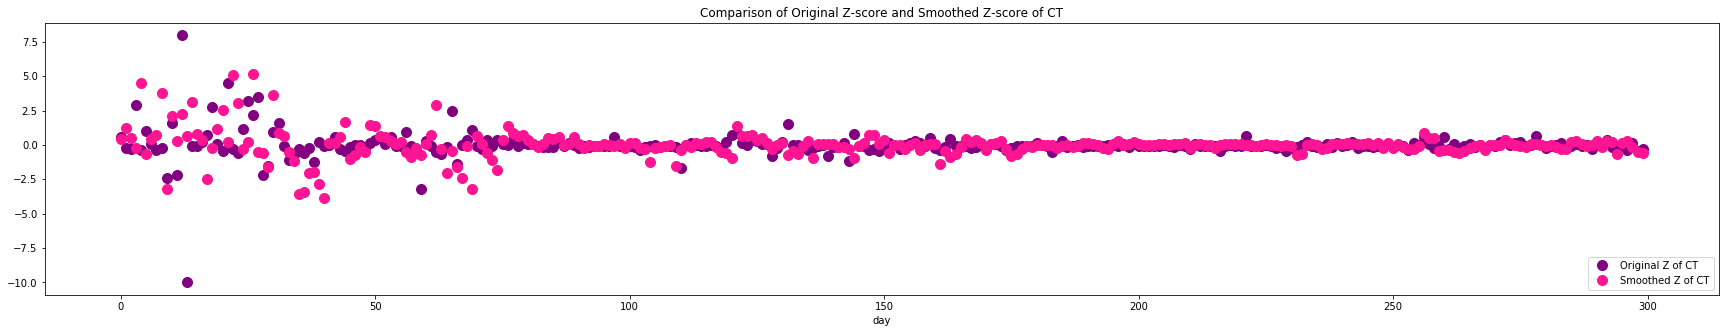

In [102]:
def z_score_smooth(delta, ave, std, period):
    z_score = np.zeros(period)
    for idx_d, delta_day in enumerate(delta):
        z_day = np.divide(np.subtract(delta_day, ave), std)
        z_score[idx_d] = z_day
    return z_score

print("mean", np.mean(new_delta.transpose()[CT]))
print(np.std(new_delta.transpose()[CT]))
z_ori = z_score_smooth(new_delta.transpose()[CT], np.mean(new_delta.transpose()[CT]), np.std(new_delta.transpose()[CT]), 300)
# print(z_ori)

print("mean", np.mean(new_Sdelta.transpose()[CT]))
print(np.std(new_Sdelta.transpose()[CT]))
z_smooth = z_score_smooth(new_Sdelta.transpose()[CT], np.mean(new_Sdelta.transpose()[CT]), np.std(new_Sdelta.transpose()[CT]), 300)
# print(z_smooth)

fig, ax = plt.subplots(1, 1)
fig.set_figheight(5)
fig.set_figwidth(30)
ax.set_xlabel("day")
ax.set_title("Comparison of Original Z-score and Smoothed Z-score of CT")
ax.plot(np.array(range(300)),z_ori, marker='o',  markersize=10, color='purple', linewidth=0, label="Original Z of CT")
ax.plot(np.array(range(300)),z_smooth, marker='o',  markersize=10, color='deeppink', linewidth=0, label="Smoothed Z of CT")
ax.legend(loc="lower right")

Z-score Histograms

Text(0, 0.5, 'Count')

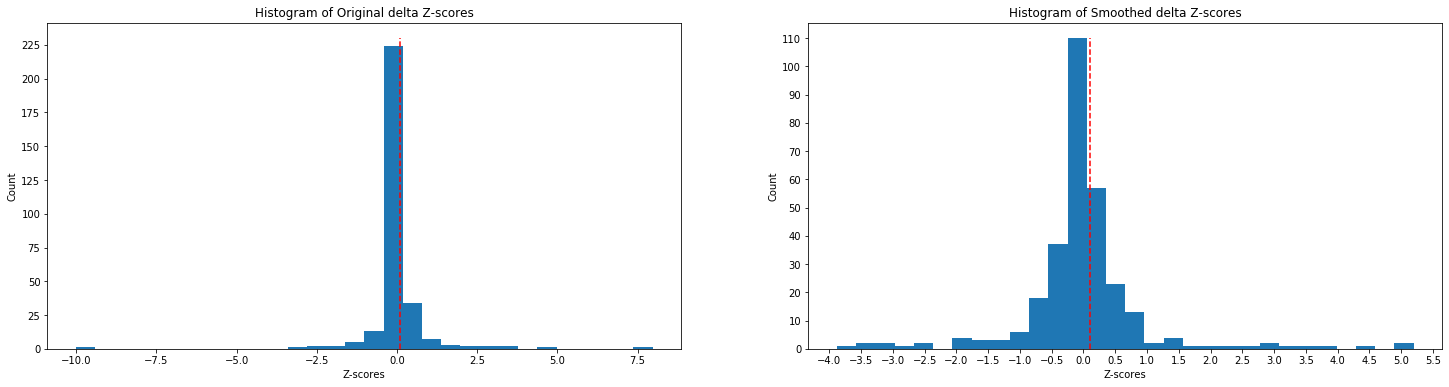

In [88]:
fig = plt.figure(figsize=(25, 6))
plt.subplot(121)
plt.hist(z_ori, bins=30)
plt.yticks(np.arange(0,300,25))
plt.plot([0.1, 0.1], [0, 230], c='r', linestyle='--')
plt.title("Histogram of Original delta Z-scores")
plt.xlabel("Z-scores")
plt.ylabel("Count")

plt.subplot(122)
plt.hist(z_smooth, bins=30)
plt.xticks(np.arange(-4,6,0.5))
plt.yticks(np.arange(0,120,10))
plt.plot([0.1, 0.1], [0, 110], c='r', linestyle='--')
plt.title("Histogram of Smoothed delta Z-scores")
plt.xlabel("Z-scores")
plt.ylabel("Count")

Different F-scores for different lags

Text(0, 0.5, 'F score')

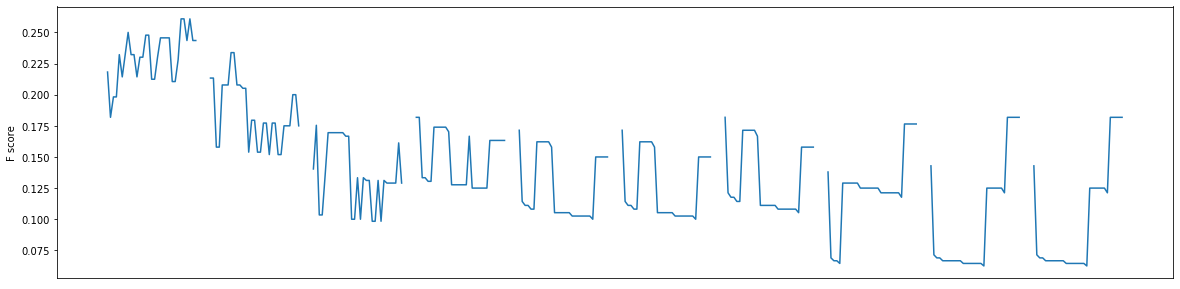

In [122]:
L_CT = covid_case_outbreak_detection_all(actual_all, "CT")
f_score = []

for th in np.arange(0.1, 2.0, 0.2):
    f_score.append(np.nan)
    f_score.append(np.nan)
    f_score.append(np.nan)
    f_score.append(np.nan)
    for l in range(31):
        L_hat_CT_S = pred_outbreak_detection(new_Sdelta, L_hat_period_all, th)
        CT_S, L_window_CT = comparison_all("US-CT", L_CT, L_hat_CT_S, l)
        metr_CT = metrics(CT_S, L_window_CT)
        f_score.append(metr_CT[4])
        
plt.figure(figsize=(20,5))
plt.plot(f_score)
plt.xticks([])
plt.ylabel("F score")

### Smoothing 7

In [124]:
Mar_smooth7 = load('results/smoothing_delta/w7/sMar20_01_31.npy')
Apr_smooth7 = load('results/smoothing_delta/w7/sApr20_01_30.npy')
May_smooth7 = load('results/smoothing_delta/w7/sMay20_01_31.npy')
Jun_smooth7 = load('results/smoothing_delta/w7/sJun20_01_30.npy')
Jul_smooth7 = load('results/smoothing_delta/w7/sJul20_01_31.npy')
Aug_smooth7 = load('results/smoothing_delta/w7/sAug20_01_31.npy')
Sept_smooth7 = load('results/smoothing_delta/w7/sSept20_01_30.npy')
Oct_smooth7 = load('results/smoothing_delta/w7/sOct20_01_31.npy')
Nov_smooth7 = load('results/smoothing_delta/w7/sNov20_01_30.npy')
Dec_smooth7 = load('results/smoothing_delta/w7/sDec20_01_31.npy')

new_delta_sMar7 = new_delta_mat(Mar_smooth7, period_31, 4, 7)[6:]
new_delta_sApr7 = new_delta_mat(Apr_smooth7, period_30, 4, 7)
new_delta_sMay7 = new_delta_mat(May_smooth7, period_31, 4, 7)
new_delta_sJun7 = new_delta_mat(Jun_smooth7, period_30, 4, 7)
new_delta_sJul7 = new_delta_mat(Jul_smooth7, period_31, 4, 7)
new_delta_sAug7 = new_delta_mat(Aug_smooth7, period_31, 4, 7)
new_delta_sSept7 = new_delta_mat(Sept_smooth7, period_30, 4, 7)
new_delta_sOct7 = new_delta_mat(Oct_smooth7, period_31, 4, 7)
new_delta_sNov7 = new_delta_mat(Nov_smooth7, period_30, 4, 7)
new_delta_sDec7 = new_delta_mat(Dec_smooth7, period_31, 4, 7)

# Joining of new delta: 7th Mar - Jan 2021
new_Sdelta7 = np.concatenate((new_delta_sMar7, new_delta_sApr7), axis=0)
new_Sdelta7 = np.concatenate((new_Sdelta7, new_delta_sMay7), axis=0)
new_Sdelta7 = np.concatenate((new_Sdelta7, new_delta_sJun7), axis=0)
new_Sdelta7 = np.concatenate((new_Sdelta7, new_delta_sJul7), axis=0)
new_Sdelta7 = np.concatenate((new_Sdelta7, new_delta_sAug7), axis=0)
new_Sdelta7 = np.concatenate((new_Sdelta7, new_delta_sSept7), axis=0)
new_Sdelta7 = np.concatenate((new_Sdelta7, new_delta_sOct7), axis=0)
new_Sdelta7 = np.concatenate((new_Sdelta7, new_delta_sNov7), axis=0)
new_Sdelta7 = np.concatenate((new_Sdelta7, new_delta_sDec7), axis=0)

Text(0.5, 1.0, 'Comparison of delta of Smoothed (w=3) Symptom Rates and Smoothed (w=7) Symptom Rates (US-CA, w=3)')

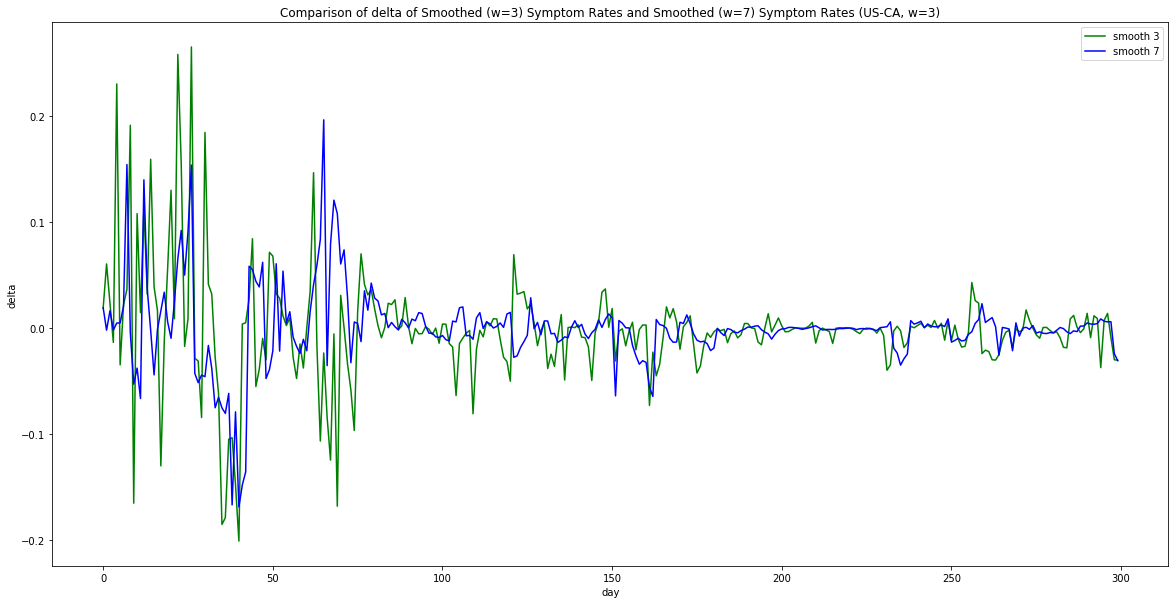

In [125]:
fig = plt.figure(figsize=(20, 10))
# plt.plot(new_delta.transpose()[CT], color='r', label="original")
plt.plot(new_Sdelta.transpose()[CT], color='g',label="smooth 3")
plt.plot(new_Sdelta7.transpose()[CT], color='blue',label="smooth 7")
plt.legend()
plt.xlabel("day")
plt.ylabel("delta")
plt.title("Comparison of delta of Smoothed (w=3) Symptom Rates and Smoothed (w=7) Symptom Rates (US-CA, w=3)")

In [126]:
# return TP_FP, FN, precision, recall, Fscore
TH = np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0])
lag = np.arange(0,31)
state_best_th_lag7 = np.zeros((NUM_STATES,2))

for idx_s, state in enumerate(STATES):
    best_th_lag = np.zeros(2)
    best_lag = 0
    best_f_score = 0
    target = state[3:]
    L = covid_case_outbreak_detection_all(actual_all, target)
    
    for idx_th, th in enumerate(TH):
        for idx_l, l in enumerate(lag):   
            
            L_hat7 = pred_outbreak_detection(new_Sdelta7, L_hat_period_all, th)
            all_S7, L_window7 = comparison_all(state, L, L_hat7, l)
            metr = metrics(all_S7, L_window7)
            
            if metr[4] > best_f_score:
                best_th_lag[0] = th
                best_th_lag[1] = l
                best_f_score = metr[4]
                
    state_best_th_lag7[idx_s] = best_th_lag
np.save("best_th_lag_smooth7.npy", state_best_th_lag7)

/Users/nadhirahrafidz/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/nadhirahrafidz/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


In [128]:
state_best_th_lag_S7 = load('best_th_lag_smooth7.npy')
state_TP_FP_S7 = np.zeros((NUM_STATES,2))
state_FN_S7 = np.zeros(NUM_STATES)
state_fscore_S7 = np.zeros(NUM_STATES)
state_precision_S7 = np.zeros(NUM_STATES)
state_recall_S7 = np.zeros(NUM_STATES)

total_real_anomalies_S7 = np.zeros(NUM_STATES)

for idx_s, state in enumerate(STATES):
    target = state[3:]    
    L_S = covid_case_outbreak_detection_all(actual_all, target)
            
    L_hat_S7 = pred_outbreak_detection(new_Sdelta7, L_hat_period_all, state_best_th_lag_S7[idx_s][0])
    all_S_smooth7, L_window_S7 = comparison_all(state, L_S, L_hat_S7, int(state_best_th_lag_S7[idx_s][1]))
    
    total_real_anomalies_S7[idx_s] = np.sum(L_window_S7)
    metr = metrics(all_S_smooth7, L_window_S7)
    state_TP_FP_S7[idx_s] = metr[0]
    state_FN_S7[idx_s] = metr[1]
    state_precision_S7[idx_s] = metr[2]
    state_recall_S7[idx_s] = metr[3]
    state_fscore_S7[idx_s] = metr[4]

In [156]:
print(np.mean(state_fscore_S7))

0.3340620849645265


Plotting symptom rate anomalies of w=3 and w=7 (first 25 states only)

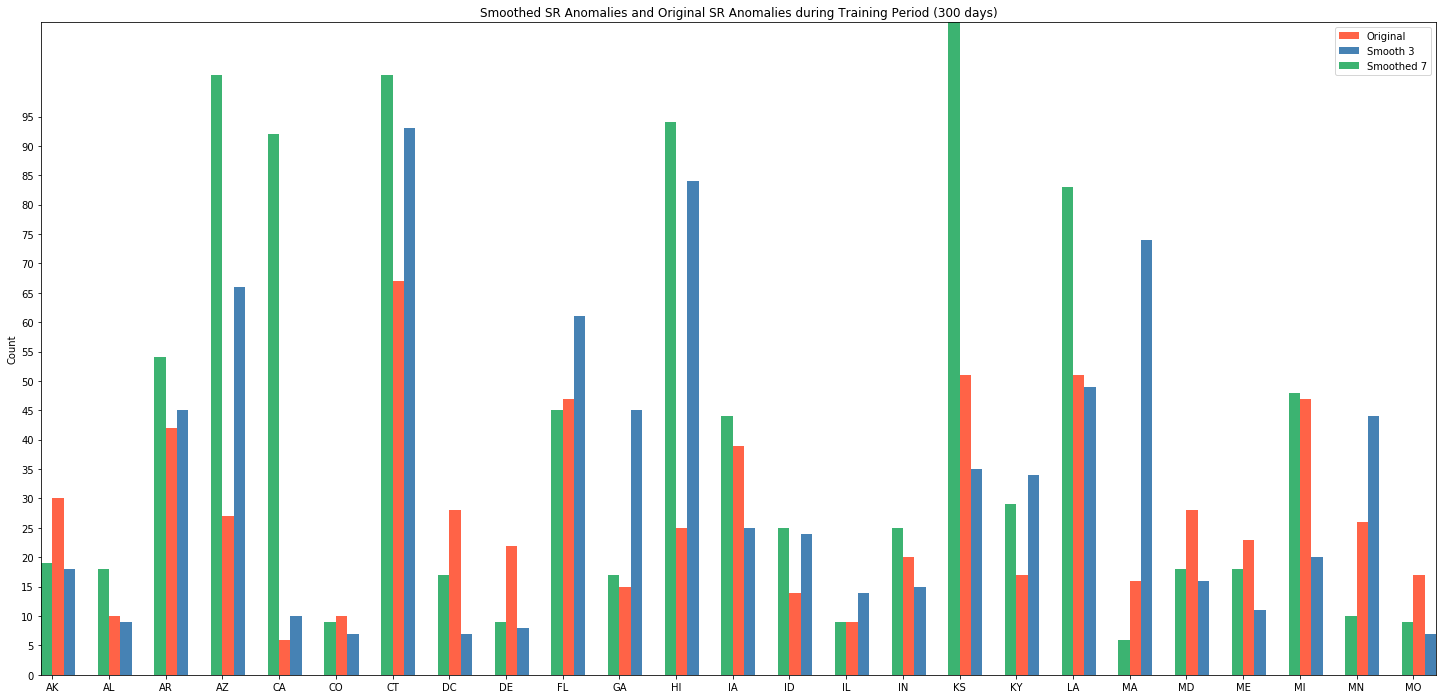

In [157]:
fig = plt.figure(figsize=(25, 12))
ax = fig.add_subplot(111)
_X = np.arange(25)
X = [state[3:] for state in STATES[:25]]
ax.bar(_X + 0.1, [int(TP_FP[0]+TP_FP[1]) for TP_FP in state_TP_FP_ori[:25]], width=0.2, color='tomato', align='center', label="Original")
ax.bar(_X + 0.3, [int(TP_FP[0]+TP_FP[1]) for TP_FP in state_TP_FP_S[:25]], width=0.2, color='steelblue', align='center', label="Smooth 3")
ax.bar(_X - 0.1, [int(TP_FP[0]+TP_FP[1]) for TP_FP in state_TP_FP_S7[:25]], width=0.2, color='mediumseagreen', align='center', label="Smoothed 7")
ax.autoscale(tight=True)
plt.xticks(_X, X)
plt.yticks(range(0, 100, 5))
plt.title("Smoothed SR Anomalies and Original SR Anomalies during Training Period (300 days)")
plt.ylabel("Count")
plt.legend()
plt.show()

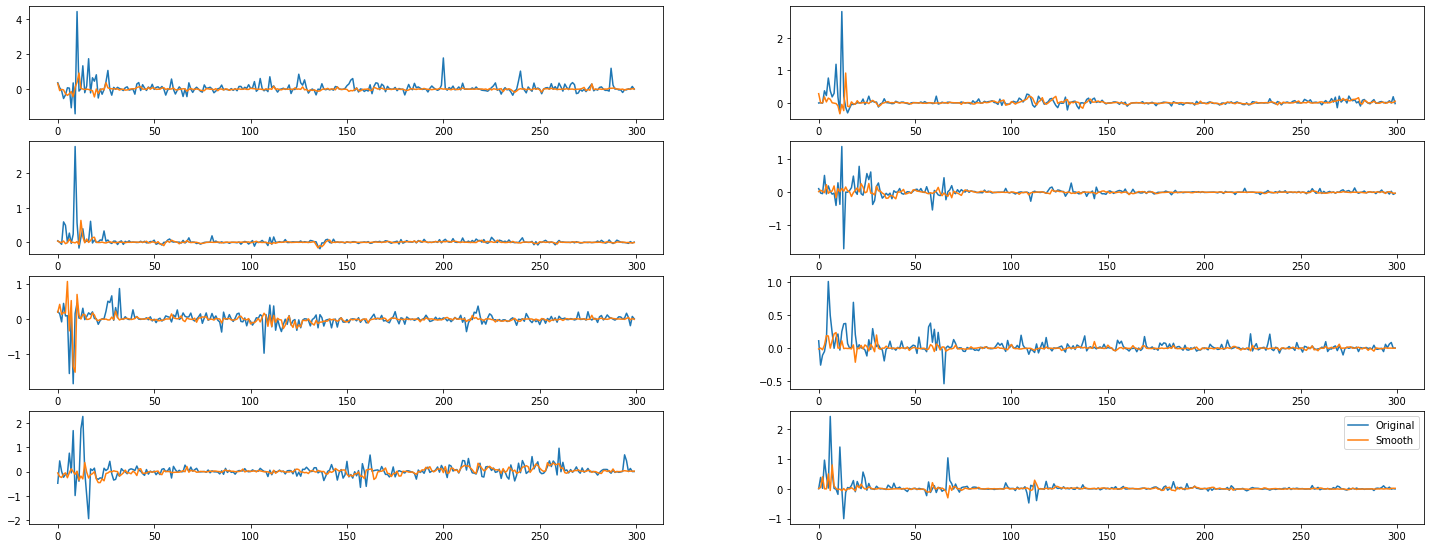

In [178]:
fig = plt.figure(figsize=(25, 12))
plt.subplot(521)
plt.plot(new_delta.transpose()[0], label="Original")
plt.plot(new_Sdelta.transpose()[0], label="Smooth")
plt.subplot(522)
plt.plot(new_delta.transpose()[4], label="Original")
plt.plot(new_Sdelta.transpose()[4], label="Smooth")
plt.subplot(523)
plt.plot(new_delta.transpose()[5], label="Original")
plt.plot(new_Sdelta.transpose()[5], label="Smooth")
plt.subplot(524)
plt.plot(new_delta.transpose()[6], label="Original")
plt.plot(new_Sdelta.transpose()[6], label="Smooth")
plt.subplot(525)
plt.plot(new_delta.transpose()[7], label="Original")
plt.plot(new_Sdelta.transpose()[7], label="Smooth")
plt.subplot(526)
plt.plot(new_delta.transpose()[8], label="Original")
plt.plot(new_Sdelta.transpose()[8], label="Smooth")
plt.subplot(527)
plt.plot(new_delta.transpose()[11], label="Original")
plt.plot(new_Sdelta.transpose()[11], label="Smooth")
plt.subplot(528)
plt.plot(new_delta.transpose()[24], label="Original")
plt.plot(new_Sdelta.transpose()[24], label="Smooth")
plt.legend()

Covid-19 Case Anomalies For States Corresponding to Graph above

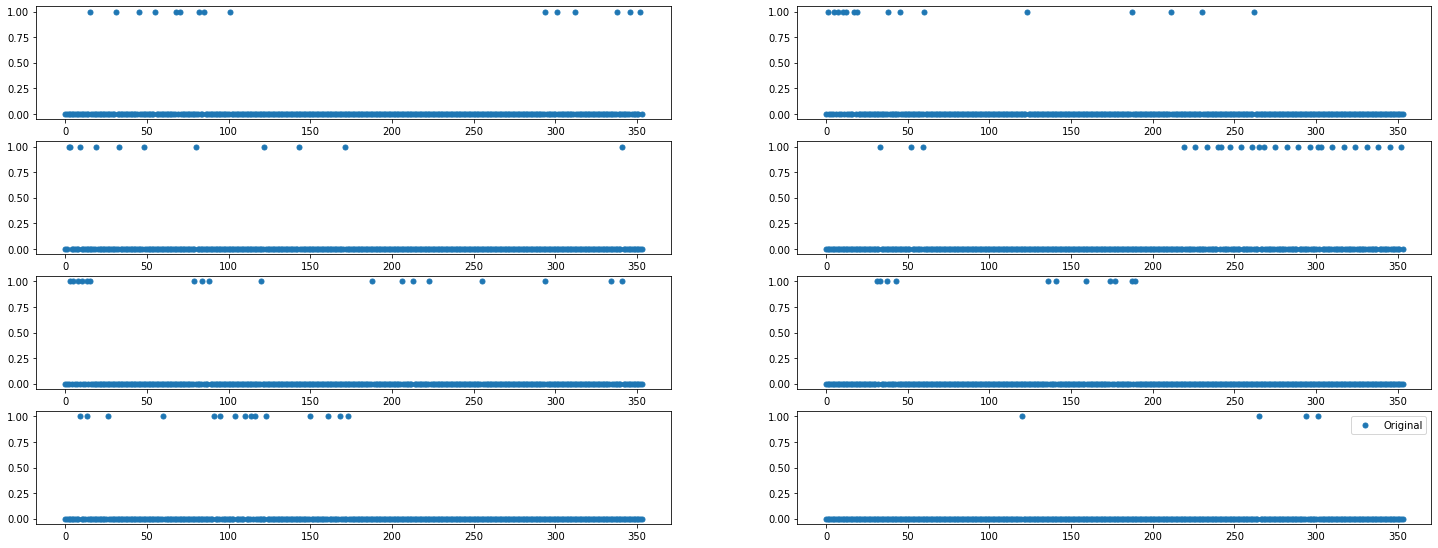

In [191]:
fig = plt.figure(figsize=(25, 12))
plt.subplot(521)
plt.plot(covid_case_outbreak_detection_all(actual_all, "AK"), linewidth=0, marker='o',  markersize=5,label="Original")
# plt.plot(new_Sdelta.transpose()[0], label="Smooth")
plt.subplot(522)
plt.plot(covid_case_outbreak_detection_all(actual_all, "CA"), marker='o',  markersize=5,linewidth=0,label="Original")
# plt.plot(new_Sdelta.transpose()[4], label="Smooth")
plt.subplot(523)
plt.plot(covid_case_outbreak_detection_all(actual_all, "CO"), marker='o',  markersize=5,linewidth=0,label="Original")
# plt.plot(new_Sdelta.transpose()[5], label="Smooth")
plt.subplot(524)
plt.plot(covid_case_outbreak_detection_all(actual_all, "CT"), marker='o',  markersize=5,linewidth=0,label="Original")
# plt.plot(new_Sdelta.transpose()[6], label="Smooth")
plt.subplot(525)
plt.plot(covid_case_outbreak_detection_all(actual_all, "DC"), marker='o',  markersize=5,linewidth=0,label="Original")
# plt.plot(new_Sdelta.transpose()[7], label="Smooth")
plt.subplot(526)
plt.plot(covid_case_outbreak_detection_all(actual_all, "DE"), marker='o',  markersize=5,linewidth=0,label="Original")
# plt.plot(new_Sdelta.transpose()[8], label="Smooth")
plt.subplot(527)
plt.plot(covid_case_outbreak_detection_all(actual_all, "HI"), marker='o',  markersize=5,linewidth=0,label="Original")
# plt.plot(new_Sdelta.transpose()[11], label="Smooth")
plt.subplot(528)
plt.plot(covid_case_outbreak_detection_all(actual_all, "MN"), marker='o',  markersize=5,linewidth=0,label="Original")
# plt.plot(new_Sdelta.transpose()[24], label="Smooth")
plt.legend()

# Experiment: Covid-19 Testing

Text(0, 0.5, 'Count')

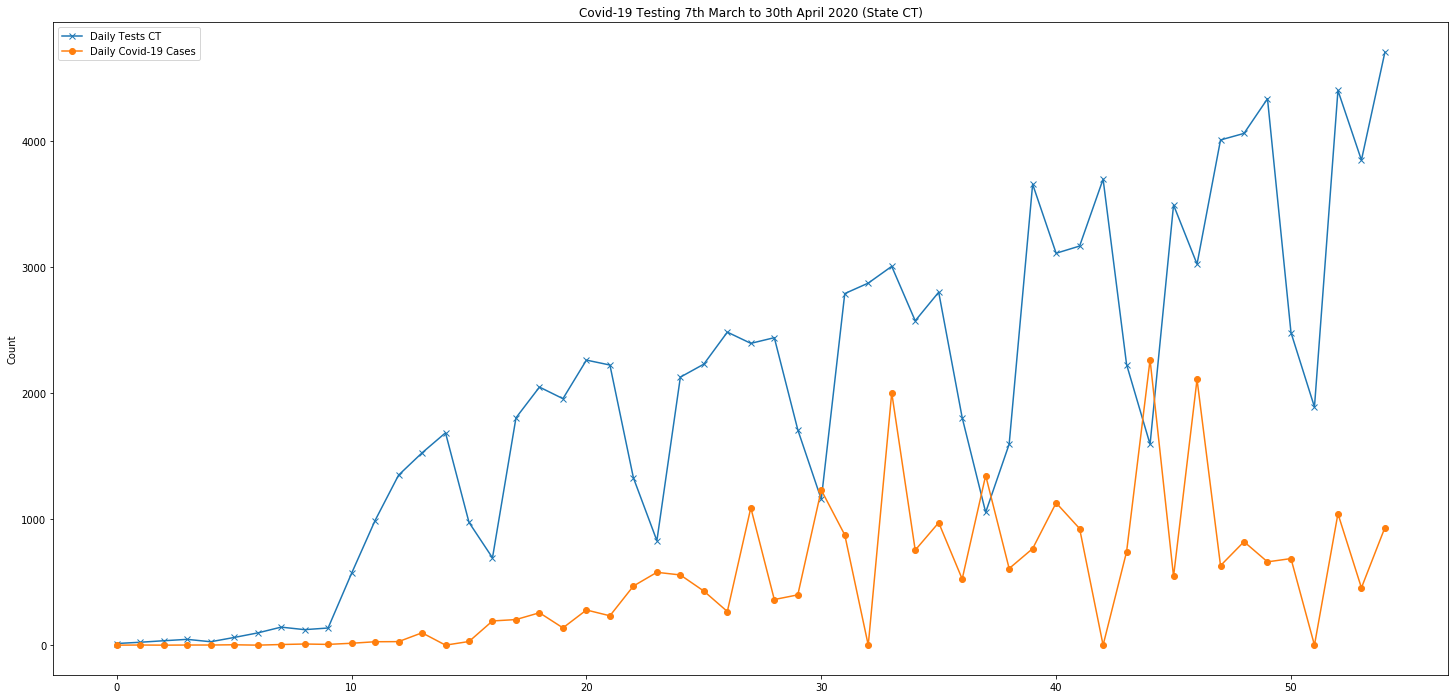

In [235]:
fig = plt.figure(figsize=(25, 12))
# plt.plot(get_daily_tests("NC", "2020-03-06", "2020-12-31")[1:].to_numpy(), marker="x", label="Daily Tests NC")
plt.plot(get_daily_tests("CT", "2020-03-06", "2020-04-30")[1:].to_numpy(), marker="x", label="Daily Tests CT")
plt.plot(actual_all[(actual_all.date >= "2020-03-06") & (actual_all.date <= "2020-04-30") & (actual_all.state == "CT")]["positiveIncrease"].to_numpy(), marker="o", label="Daily Covid-19 Cases")
# plt.plot(np.arange(0,55,1),np.full(55, 1957))
plt.legend()
plt.title("Covid-19 Testing 7th March to 30th April 2020 (State CT)")
plt.ylabel("Count")

# Testing (Based on Exp 1)

## Preparing Data: L HAT

Testing period: 1 Jan 2021 - 5 February 2021 (36 days)

In [68]:
new_delta_testing = np.concatenate((new_delta_Jan21, new_delta_Feb21[:5]), axis=0)
testing_period = len(new_delta_testing)
print(testing_period, "days")

test_ave_mat = average_delta(testing_period, new_delta_testing)
test_std_mat = std_dev_delta(testing_period, new_delta_testing)

36 days


In [69]:
actual_testing = actual_cases_testing[(actual_cases_testing.date >= "2020-03-07") & (actual_cases_testing.date <= "2021-03-07")]
print(actual_testing.date.nunique(), "days")
#REMEMBER TO EXCLUDE L[0]! (31st Dec 2020)
# 67 days initially

366 days


In [70]:
def z_score_test(delta_region_day, ave, std, period):
    z_score = np.zeros(period)
    for idx_d, delta in enumerate(delta_region_day):
        z_day = np.divide(np.subtract(delta, ave), std)
        z_score[idx_d] = z_day
    return z_score

def comparison_test(L, L_hat_region, lag):
    period = len(L_hat_region) 
    L_window = window_L(L, lag, period)
    Lw = np.zeros(7)
    S = np.zeros((period, 2))
    counted = []
    for idx_L, L_hat_day in enumerate(L_hat_region): 
        if idx_L < 3: 
            w = np.arange(0, (idx_L+4))
        elif idx_L >= (period-3):
            w = np.arange((idx_L-3), period)
        else: 
            w = np.arange((idx_L-3), (idx_L+4))
        Lw = L_window[w]
        s = np.zeros(2)
        if L_hat_day == 1:
            # Is there an outbreak in the Lw window? Get position of outbreak in window
            L_outbreaks = np.argwhere(Lw == 1).flatten()
            # Get outbreak date index
            date_idx_L_outbreaks = w[L_outbreaks]
            # Check to see if the indexes of outbreak dates has been counted. 
            new_outbreaks = np.setdiff1d(date_idx_L_outbreaks, np.array(counted))
            if new_outbreaks.shape[0] > 0:
                idx_outbreak = new_outbreaks[0]
                s[0] = 1
                counted.append(idx_outbreak)
            else:
                s[1] = 1
        S[idx_L] = s
    return S, L_window

def test(test_delta, actual_testing, testing_period, ave_mat, std_mat, best_th_lag):
    f_score = np.zeros(NUM_STATES)
    TP_FP = np.zeros((NUM_STATES,2))
    FN = np.zeros(NUM_STATES)
    true_anomalies = np.zeros(NUM_STATES)
    
    for idx_s, state in enumerate(STATES):
        target = state[3:]
        L_test = covid_case_outbreak_detection_all(actual_testing, target)
        
        # Testing period start 1st Jan
        L_test_p = L_test[300:]
        
        test_delta_region = test_delta.transpose()[idx_s]
        z_score_region = z_score_test(test_delta_region, ave_mat[idx_s], std_mat[idx_s], testing_period)
        L_hat_testing = L_score(z_score_region, best_th_lag[idx_s][0]) 
        
        S_test, L_window_test = comparison_test(L_test, L_hat_testing, int(best_th_lag[idx_s][1]))
        met = metrics(S_test, L_window_test)
        
        true_anomalies[idx_s] = np.sum(L_window_test)
        f_score[idx_s] = met[4]
        TP_FP[idx_s] = met[0]
        FN[idx_s] = met[1]
    return f_score, TP_FP, FN, true_anomalies

In [71]:
f_test, TP_FP_test, FN_test, L_window_sum = test(new_delta_testing, actual_testing, testing_period, test_ave_mat, test_std_mat, state_best_th_lag)

/Users/nadhirahrafidz/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
/Users/nadhirahrafidz/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


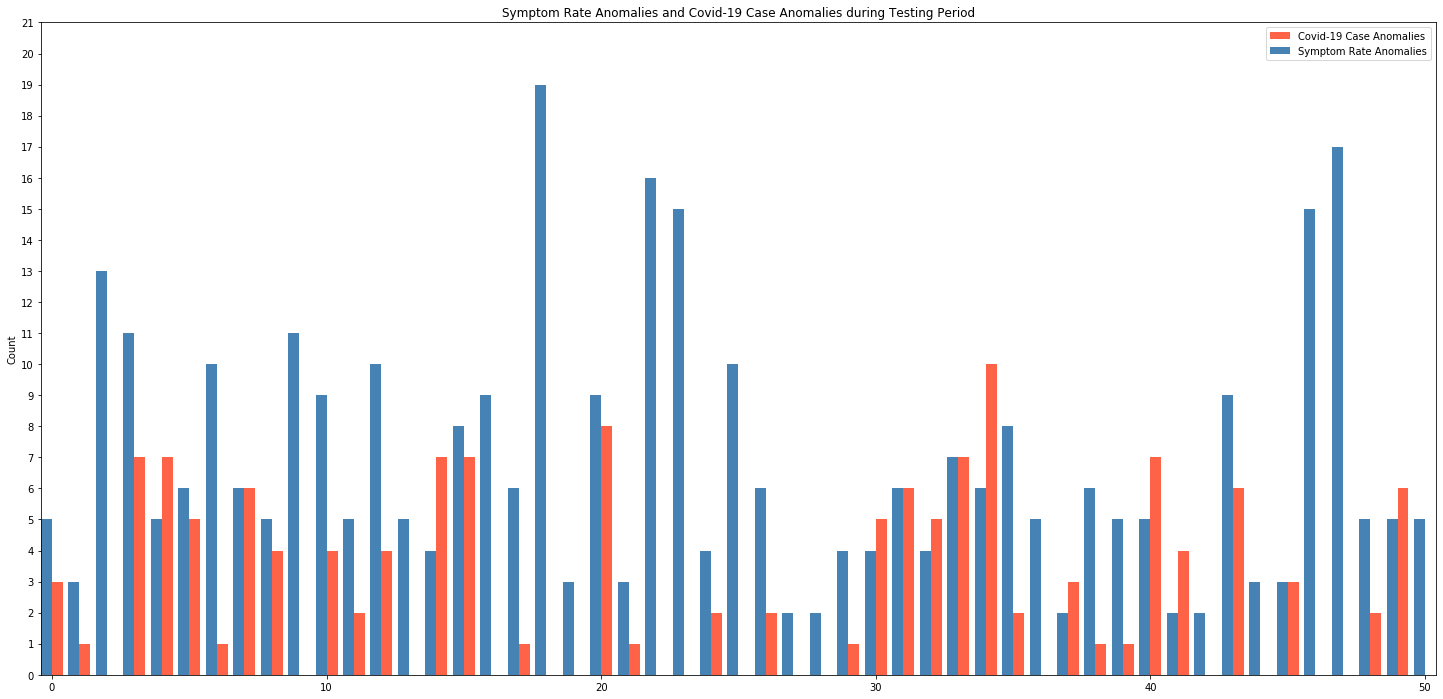

In [146]:
fig = plt.figure(figsize=(25, 12))
ax = fig.add_subplot(111)
_X = np.arange(NUM_STATES)
X = [state[3:] for state in STATES]
ax.bar(_X + 0.2, [int(L_window) for L_window in L_window_sum], width=0.4, color='tomato', align='center', label="Covid-19 Case Anomalies")
ax.bar(_X - 0.2, [int(TP_FP[0]+TP_FP[1]) for TP_FP in TP_FP_test], width=0.4, color='steelblue', align='center', label="Symptom Rate Anomalies")
ax.autoscale(tight=True)
plt.yticks(range(0, 22))
plt.title("Symptom Rate Anomalies and Covid-19 Case Anomalies during Testing Period")
plt.ylabel("Count")
plt.legend()
plt.show()

#### Saving values

In [73]:
np.savetxt("f_test.csv", f_test, delimiter=",")
np.savetxt("TP_FP_test.csv", TP_FP_test, delimiter=",")
np.savetxt("FN_test.csv", FN_test, delimiter=",")
np.savetxt("L_window_sum_test.csv", L_window_sum, delimiter=",")

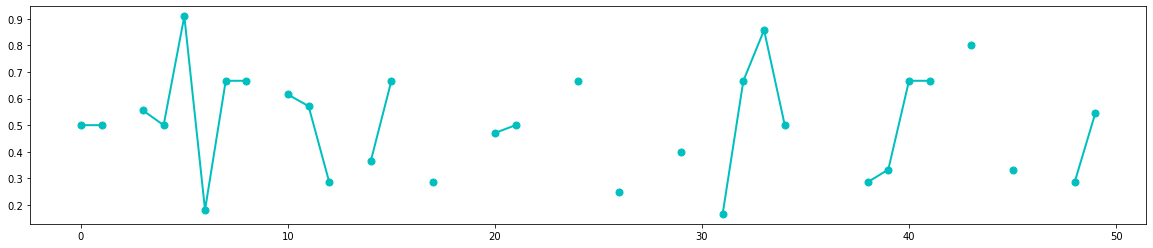

In [74]:
fig, ax = plt.subplots(1, 1)
fig.set_figheight(4)
fig.set_figwidth(20)
all = ax.plot(np.array(range(len(f_test))),f_test, marker='o',  markersize=7, color='c', linewidth=2)

In [ ]:
# plt.subplot(331)
# plt.plot(Mar_smooth[:,4,4], label="Smooth")
# plt.subplot(331)
# plt.plot(data_Mar[:,4,4], label="Original")
# plt.subplot(332)
# plt.plot(Apr_smooth[:,4,4], label="Smooth")
# plt.plot(data_Apr[:,4,4], label="Original")
# plt.subplot(333)
# plt.plot(May_smooth[:,4,4], label="Smooth")
# plt.plot(data_May[:,4,4], label="Original")
# plt.subplot(334)
# plt.plot(Jun_smooth[:,4,4], label="Smooth")
# plt.plot(data_Jun[:,4,4], label="Original")
# plt.subplot(335)
# plt.plot(Jul_smooth[:,4,4], label="Smooth")
# plt.plot(data_Jul[:,4,4], label="Original")
# plt.subplot(336)
# plt.plot(Aug_smooth[:,4,4], label="Smooth")
# plt.plot(data_Aug[:,4,4], label="Original")
# plt.subplot(337)
# plt.plot(Sept_smooth[:,4,4], label="Smooth")
# plt.plot(data_Sept[:,4,4], label="Original")
# plt.subplot(338)
# plt.plot(Oct_smooth[:,4,4], label="Smooth")
# plt.plot(data_Oct[:,4,4], label="Original")
# plt.subplot(339)
# plt.plot(Dec_smooth[:,4,0], label="Smooth")
# plt.plot(data_Dec[:,4,4], label="Original")